# 5.2 . SARIMA model - Detailed

### We are here testing the SARIMA model on the whole day. RMSE of forecast vs backtest will help assess the model right

## I. Declarations

In [4]:
# Library Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit

from statsmodels.tsa.api import SARIMAX
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings


In [5]:
# Creating list of times to start the prediction
#warnings.filterwarnings("ignore")
time = pd.Timestamp("00:00:00")
time_list = []
time_list.append(str(time)[-8:])

# Adding 15 minutes every time
#for i in range(1):
for i in range(24*4-1):
    time += pd.Timedelta(minutes=15)
    time_list.append(str(time)[-8:])
print(time_list)

['00:00:00', '00:15:00', '00:30:00', '00:45:00', '01:00:00', '01:15:00', '01:30:00', '01:45:00', '02:00:00', '02:15:00', '02:30:00', '02:45:00', '03:00:00', '03:15:00', '03:30:00', '03:45:00', '04:00:00', '04:15:00', '04:30:00', '04:45:00', '05:00:00', '05:15:00', '05:30:00', '05:45:00', '06:00:00', '06:15:00', '06:30:00', '06:45:00', '07:00:00', '07:15:00', '07:30:00', '07:45:00', '08:00:00', '08:15:00', '08:30:00', '08:45:00', '09:00:00', '09:15:00', '09:30:00', '09:45:00', '10:00:00', '10:15:00', '10:30:00', '10:45:00', '11:00:00', '11:15:00', '11:30:00', '11:45:00', '12:00:00', '12:15:00', '12:30:00', '12:45:00', '13:00:00', '13:15:00', '13:30:00', '13:45:00', '14:00:00', '14:15:00', '14:30:00', '14:45:00', '15:00:00', '15:15:00', '15:30:00', '15:45:00', '16:00:00', '16:15:00', '16:30:00', '16:45:00', '17:00:00', '17:15:00', '17:30:00', '17:45:00', '18:00:00', '18:15:00', '18:30:00', '18:45:00', '19:00:00', '19:15:00', '19:30:00', '19:45:00', '20:00:00', '20:15:00', '20:30:00', '20

## II. Model pipe

In [6]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# create a set of exponential smoothing configs to try
def sarima_configs(seasonal=[None]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = [ 'n' , 'c' , 't' , 'ct' ]
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

# one-step Holt Winters Exponential Smoothing forecast
def sarima_forecast_grid_search(train, test, configurations):
    best_config = ""
    best_rmse = 99999
    for i in range(len(configurations)):
        try:
            order, sorder, trend = configurations[i]

            # define model
            model = SARIMAX(train, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

            # predict n values, the length of test arry
            pred = model.predict(start=len(train)+1,end=len(test)+len(train))
            temp_indicator = measure_rmse(test,pred)
            if temp_indicator < best_rmse:
                best_rmse = temp_indicator
                best_config = configurations[i]
        except:
            pass
    return(best_config, best_rmse)

In [7]:
def model_generation(time, time_step, config):

    # I. INITIALIZATION OF THE MODEL
    
    start_time = timeit.default_timer()
    # Timestamp of when we want to start the prediction
    target_start = time
    # n-1 minutes before the target date and n min after
    time_variation = time_step
    # Loading from github the dataset. It is an extract of the madeleine station only
    df_station = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")

    # II. PREPROCESSING PIPE
    # Removing first not useless column
    df_station.pop("Unnamed: 0")

    # Adding day and minute
    df_station["day"] = df_station.date.apply(lambda x: x[:10])

    # Converting to datetime the number of availiable docks
    df_station['date'] = pd.to_datetime(df_station['date'])

    # Variable declaration

    # list the different days. Removing 2020_01_15 for lack of data.
    day_list = df_station.day.unique()

    #removing first day (incomplete data) and last day (only midnight)
    day_list = day_list[1:-1]

    # Creation of time bounds
    lower_time_bound = str(pd.Timestamp(target_start) - pd.Timedelta(minutes=time_variation))[-8:]
    upper_time_bound = str(pd.Timestamp(target_start) + pd.Timedelta(minutes=time_variation+1))[-8:]

    # proper consolidation
    df_conso = pd.DataFrame(columns=df_station.columns)
    for i in range(len(day_list)-1):

        # The 30 min after the time, the day before

        day_lower = day_list[i]
        df_day_lower = df_station[df_station["day"] == day_lower]
        df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_lower, target_start))
                    & (df_day_lower["date"] < "{} {}".format(day_lower,upper_time_bound))]


        # The 30 min before the time, the day 


        day_upper = day_list[i+1]
        df_day_upper = df_station[df_station["day"] == day_upper]
        df_day_upper = df_day_upper[(df_day_upper["date"] > "{} {}".format(day_upper, lower_time_bound))
                    & (df_day_upper["date"] <= "{} {}".format(day_upper,target_start))]

        df_conso = pd.concat([df_conso, df_day_lower, df_day_upper])

    # Backtest for ulterior use
    day_backtest = day_list[len(day_list)-1]
    df_day_lower = df_station[df_station["day"] == day_backtest]
    df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_backtest, target_start))
                & (df_day_lower["date"] < "{} {}".format(day_backtest,upper_time_bound))]["availiable_docks"]
    df_backtest = np.array(df_day_lower)



    df_conso = df_conso.reset_index(drop="True")

    # Converting to int the number of availiable docks
    df_conso["availiable_docks"] = df_conso["availiable_docks"].astype(int)
    df_conso.head()

    # Creating time_serie
    time_serie = np.array(df_conso["availiable_docks"])

    # Doing a slit of aust between train and test
    split_ratio = 1- 1/(len(time_serie)/(time_variation*2))
    train = time_serie[0:int(round(len(time_serie)*split_ratio,0))]
    test = time_serie[int(round(len(time_serie)*split_ratio,0)):]


    # This will be our performance indicator
    

    cfg_list = config
    
    # B. Finding the best parameters over one periode
    best_parameters, best_rmse = sarima_forecast_grid_search(train, test, cfg_list)

    # Loading the best parameters found befor
    order, sorder, trend = best_parameters 

    # Creating the model on full time serie

    model = SARIMAX(train, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    # C. Training on full time serie to optimize before prediction¶

    # Creating the model on full time serie, using best parameters

    model = SARIMAX(time_serie, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    
    # predicting on all time serie for global RMSE
    pred_model = model.predict(1,end=len(time_serie))
    RMSE_test = measure_rmse(time_serie,pred_model)


    # Prediction the dataset + time variation
    final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))


    # IV - Making the prediction up to the time variation and creating assessment dataframe

    # Creating a dataframe for assessement
    df_assessement = pd.DataFrame(columns=["actual","forecast_first_run","forecast_optimized","forecast_optimized_round","backtest"])
    # Setting actual at the last known value
    df_assessement.actual = (np.concatenate((time_serie, (np.zeros(time_variation)+time_serie[-1:])), axis = 0))
    # Setting forecast at time_serie for the past and the final prediction for the futur
    df_assessement.forecast_optimized = (np.concatenate((time_serie, final_prediction), axis = 0))
    df_assessement.forecast_optimized_round = df_assessement.forecast_optimized.apply(lambda x:round(x,0))
    df_assessement.backtest = (np.concatenate((time_serie, df_backtest), axis = 0))
    df_assessement["date"] = df_conso["date"]
    # Making a synthetic dataset for easier visualisation

    df_assessement_small = df_assessement[-time_variation*2:]

    # V. SYNTHSIS

    # Time to run

    elapsed = timeit.default_timer() - start_time


    # RMSE for assessement

    rmse_f_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized[time_variation:])
    rmse_rf_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized_round[time_variation:])
    #reminder of best parameters

    results = [str(target_start)[-8:], rmse_f_b, rmse_rf_b, RMSE_test, best_parameters, elapsed]
    return results

In [8]:
# Setting the configurations to test 

config = sarima_configs(seasonal=[60])
config[:5]

[[(0, 0, 0), (0, 0, 0, 60), 'n'],
 [(0, 0, 0), (0, 0, 1, 60), 'n'],
 [(0, 0, 0), (0, 0, 2, 60), 'n'],
 [(0, 0, 0), (0, 1, 0, 60), 'n'],
 [(0, 0, 0), (0, 1, 1, 60), 'n']]

In [9]:
# Trying with the optimised config
config = []
config.append("a")
config.append([(1, 1, 1), (2, 1, 0, 60), 'ct'])


In [10]:
config

['a', [(1, 1, 1), (2, 1, 0, 60), 'ct']]

In [11]:
# Creating a result list to assess the results
# Here, the model will be trained for every hour and will output:
# - time
# - RMSE forecast vs backtest
# - RMSE round forecast vs backtest
# - RMSE forecast vs backtest from the first test
# - The best parameters
# - The time elapsed to run the pipe


result = []
step =0
for i in time_list[36:]:
    step += 1
    try:
        temp = model_generation(i, 30, config)
        result.append(temp)
        print(temp)
    except:
        pass
    print("progression:",step,"/",len(time_list))

['09:00:00', 6.769197788788247, 6.680818313150967, 1.0247059489560353, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 961.3540816520001]
progression: 1 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['09:15:00', 5.204600979550043, 5.186520991955976, 0.8818364852382057, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 889.647159873]
progression: 2 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['09:30:00', 1.5221990192784876, 1.5275252316519468, 0.9809699292606577, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 968.130792848]
progression: 3 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['09:45:00', 3.685331381121168, 3.678767909685705, 0.9959430598587707, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1250.478776585]
progression: 4 / 96
['10:00:00', 7.352783911994223, 7.411702458499891, 1.1939868681852337, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 814.9712049]
progression: 5 / 96
['10:15:00', 2.4631510452000054, 2.581988897471611, 0.9934637357502193, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 716.8174196090004]
progression: 6 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['10:30:00', 3.0652314632071684, 3.022140521771503, 0.9469226700638798, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1412.8737603460004]
progression: 7 / 96
['10:45:00', 16.758171996416642, 16.812693617224657, 0.944384318579582, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 419.16413824899973]
progression: 8 / 96
['11:00:00', 4.346616018459222, 4.385582439463809, 0.7478816428051195, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1167.3848290140004]
progression: 9 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['11:15:00', 1.2375853402909953, 1.3038404810405297, 0.6028741092401863, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1322.815428848]
progression: 10 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['11:30:00', 1.6176453452814499, 1.5275252316519468, 0.5446967049344444, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1242.2350387040005]
progression: 11 / 96
['11:45:00', 1.9798723164284298, 1.9578900207451218, 0.8305010190755416, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 922.2448103850002]
progression: 12 / 96
['12:00:00', 1.8072081672725557, 1.8257418583505538, 0.6666091679741722, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 941.9942236300012]
progression: 13 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['12:15:00', 5.9125396126030685, 5.785038173311103, 0.7249152104251296, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 960.42847755]
progression: 14 / 96
['12:30:00', 4.454922355593751, 4.505552130427524, 0.7456435506257119, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 801.707973442999]
progression: 15 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['12:45:00', 1.828066633810997, 1.8618986725025255, 0.7072808726713553, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1081.2795639789983]
progression: 16 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['13:00:00', 2.499463362422897, 2.5298221281347035, 0.893738151485921, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1053.010286558998]
progression: 17 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['13:15:00', 6.925382356594605, 6.867799259345505, 0.9312018740679597, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1185.885515992999]
progression: 18 / 96
progression: 19 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['13:45:00', 2.0750530808143597, 2.1291625896895083, 1.139598862796795, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1212.6699552280006]
progression: 20 / 96
['14:00:00', 2.6405807458650505, 2.594866727470475, 1.2294221966704941, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 966.9904637489999]
progression: 21 / 96
['14:15:00', 2.644536483978328, 2.652043237455478, 0.8940541105977984, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 904.2796031559992]
progression: 22 / 96
['14:30:00', 1.2610117895175514, 1.2649110640673518, 0.870643115239312, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 716.0330782860001]
progression: 23 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['14:45:00', 2.2235825790930313, 2.183269719175042, 0.676433025670064, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1063.5340907060017]
progression: 24 / 96
['15:00:00', 4.552644169955943, 4.560701700396552, 0.5952640552500048, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 907.4487698049998]
progression: 25 / 96
['15:15:00', 3.0231145634162306, 3.022140521771503, 0.6199469644798091, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1188.0504894389996]
progression: 26 / 96
['15:30:00', 3.9680737424150205, 3.966526608171604, 0.44171722276992137, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 672.2900433659997]
progression: 27 / 96
['15:45:00', 5.064404469549371, 4.888762624632126, 0.4339388876553513, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 516.0327605769999]
progression: 28 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['16:00:00', 2.38950834908276, 2.3804761428476167, 0.5827357333638755, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1321.883574263]
progression: 29 / 96
['16:15:00', 1.241307622995468, 1.378404875209022, 0.5201019748849638, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 477.00997534699854]
progression: 30 / 96
['16:30:00', 1.336845302515162, 1.2780193008453875, 0.5050199203676524, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 838.4323631600018]
progression: 31 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['16:45:00', 1.527937544628079, 1.559914527573012, 0.5535224624796806, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1013.4033820730001]
progression: 32 / 96
['17:00:00', 1.0544294681772086, 1.0165300454651272, 0.522984176015759, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1146.4955711660004]
progression: 33 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['17:15:00', 4.306856624259355, 4.262237284181474, 0.6193774136258235, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1063.9183476849976]
progression: 34 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['17:30:00', 3.886008997989896, 3.902990306589722, 0.681525964090938, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1237.4466965839965]
progression: 35 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['17:45:00', 1.2446913722018378, 1.3291601358251257, 0.7370292606164079, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 918.9072142739969]
progression: 36 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['18:00:00', 1.4545803694007224, 1.4719601443879744, 0.7372511381468925, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1115.234712715006]
progression: 37 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['18:15:00', 2.4920785707192095, 2.4358434541926814, 0.8021550425590711, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 990.7115838539976]
progression: 38 / 96


/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['18:30:00', 6.9003578568953285, 6.853223086013374, 0.9233254963547927, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1114.997903161995]
progression: 39 / 96
['18:45:00', 2.3645344415822227, 2.32379000772445, 0.7048254757343289, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 459.92919406600413]
progression: 40 / 96
['19:00:00', 2.4983004494941494, 2.516611478423583, 0.6184519083109711, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 752.8948577359988]
progression: 41 / 96
['19:15:00', 3.6452386172443703, 3.6742346141747673, 0.7024671669451619, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 566.3811601909983]
progression: 42 / 96
['19:30:00', 1.165140105002175, 1.224744871391589, 0.7325876656612443, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 1057.0304082789953]
progression: 43 / 96
['19:45:00', 0.711654559744162, 0.7958224257542215, 0.6239375983109159, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 795.0543541219959]
progression: 44 / 96
['20:00:00', 2.2136667384566655, 2.243509156061845, 0.6305538891069411, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 881.9314830680014

/home/exalis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


['22:30:00', 0.30785084571302385, 0.2581988897471611, 0.4893663782516764, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 772.0369995149958]
progression: 55 / 96
['22:45:00', 0.6682089239674439, 0.6055300708194983, 0.4509141691673192, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 486.66731794699444]
progression: 56 / 96
['23:00:00', 0.742776425503622, 0.9309493362512627, 0.4466817151842466, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 908.6135135820005]
progression: 57 / 96
['23:15:00', 0.33251989621237205, 0.18257418583505536, 0.436187100233384, [(1, 1, 1), (2, 1, 0, 60), 'ct'], 682.9152826199934]
progression: 58 / 96
progression: 59 / 96
progression: 60 / 96


In [12]:
# First look at results
result

[['09:00:00',
  6.769197788788247,
  6.680818313150967,
  1.0247059489560353,
  [(1, 1, 1), (2, 1, 0, 60), 'ct'],
  961.3540816520001],
 ['09:15:00',
  5.204600979550043,
  5.186520991955976,
  0.8818364852382057,
  [(1, 1, 1), (2, 1, 0, 60), 'ct'],
  889.647159873],
 ['09:30:00',
  1.5221990192784876,
  1.5275252316519468,
  0.9809699292606577,
  [(1, 1, 1), (2, 1, 0, 60), 'ct'],
  968.130792848],
 ['09:45:00',
  3.685331381121168,
  3.678767909685705,
  0.9959430598587707,
  [(1, 1, 1), (2, 1, 0, 60), 'ct'],
  1250.478776585],
 ['10:00:00',
  7.352783911994223,
  7.411702458499891,
  1.1939868681852337,
  [(1, 1, 1), (2, 1, 0, 60), 'ct'],
  814.9712049],
 ['10:15:00',
  2.4631510452000054,
  2.581988897471611,
  0.9934637357502193,
  [(1, 1, 1), (2, 1, 0, 60), 'ct'],
  716.8174196090004],
 ['10:30:00',
  3.0652314632071684,
  3.022140521771503,
  0.9469226700638798,
  [(1, 1, 1), (2, 1, 0, 60), 'ct'],
  1412.8737603460004],
 ['10:45:00',
  16.758171996416642,
  16.812693617224657,
  

In [15]:
# Creating a dataframe with the results
df_result = pd.DataFrame(columns=["hour", "rmse_f_b", "rmse_rf_b", "RMSE_test", "best_parameters", "elapsed"])
for i in range(0, len(result)):
    df_result.loc[i] = result[i]

In [16]:
df_result

,hour,rmse_f_b,rmse_rf_b,RMSE_test,best_parameters,elapsed
0,09:00:00,6.769198,6.680818,1.024706,"[(1, 1, 1), (2, 1, 0, 60), ct]",961.354082
1,09:15:00,5.204601,5.186521,0.881836,"[(1, 1, 1), (2, 1, 0, 60), ct]",889.647160
2,09:30:00,1.522199,1.527525,0.980970,"[(1, 1, 1), (2, 1, 0, 60), ct]",968.130793
3,09:45:00,3.685331,3.678768,0.995943,"[(1, 1, 1), (2, 1, 0, 60), ct]",1250.478777
4,10:00:00,7.352784,7.411702,1.193987,"[(1, 1, 1), (2, 1, 0, 60), ct]",814.971205
5,10:15:00,2.463151,2.581989,0.993464,"[(1, 1, 1), (2, 1, 0, 60), ct]",716.817420
6,10:30:00,3.065231,3.022141,0.946923,"[(1, 1, 1), (2, 1, 0, 60), ct]",1412.873760
7,10:45:00,16.758172,16.812694,0.944384,"[(1, 1, 1), (2, 1, 0, 60), ct]",419.164138
8,11:00:00,4.346616,4.385582,0.747882,"[(1, 1, 1), (2, 1, 0, 60), ct]",1167.384829
9,11:15:00,1.237585,1.303840,0.602874,"[(1, 1, 1), (2, 1, 0, 60), ct]",1322.815429


In [17]:
# Exporting the result for further use
df_result.to_csv("/home/exalis/VELIB-DATA/github/velib-prediction/6. Model Assessement/6.2. SARIMAX_prod_results_9_00.csv")

## III. Exploring the output

We will produce here graphics to look in detail at the results

In [114]:

def model_generation_viz(time, time_step, best_parameters):

    # I. INITIALIZATION OF THE MODEL
    
    start_time = timeit.default_timer()
    # Timestamp of when we want to start the prediction
    target_start = time
    # n-1 minutes before the target date and n min after
    time_variation = time_step
    # Loading from github the dataset. It is an extract of the madeleine station only
    df_station = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")

    # II. PREPROCESSING PIPE
    # Removing first not useless column
    df_station.pop("Unnamed: 0")

    # Adding day and minute
    df_station["day"] = df_station.date.apply(lambda x: x[:10])

    # Converting to datetime the number of availiable docks
    df_station['date'] = pd.to_datetime(df_station['date'])

    # Variable declaration

    # list the different days. Removing 2020_01_15 for lack of data.
    day_list = df_station.day.unique()

    #removing first day (incomplete data) and last day (only midnight)
    day_list = day_list[1:-1]

    # Creation of time bounds
    lower_time_bound = str(pd.Timestamp(target_start) - pd.Timedelta(minutes=time_variation))[-8:]
    upper_time_bound = str(pd.Timestamp(target_start) + pd.Timedelta(minutes=time_variation+1))[-8:]

    # proper consolidation
    df_conso = pd.DataFrame(columns=df_station.columns)
    for i in range(len(day_list)-1):

        # The 30 min after the time, the day before

        day_lower = day_list[i]
        df_day_lower = df_station[df_station["day"] == day_lower]
        df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_lower, target_start))
                    & (df_day_lower["date"] < "{} {}".format(day_lower,upper_time_bound))]


        # The 30 min before the time, the day 


        day_upper = day_list[i+1]
        df_day_upper = df_station[df_station["day"] == day_upper]
        df_day_upper = df_day_upper[(df_day_upper["date"] > "{} {}".format(day_upper, lower_time_bound))
                    & (df_day_upper["date"] <= "{} {}".format(day_upper,target_start))]

        df_conso = pd.concat([df_conso, df_day_lower, df_day_upper])

    # Backtest for ulterior use
    day_backtest = day_list[len(day_list)-1]
    df_day_lower = df_station[df_station["day"] == day_backtest]
    df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_backtest, target_start))
                & (df_day_lower["date"] < "{} {}".format(day_backtest,upper_time_bound))]["availiable_docks"]
    df_backtest = np.array(df_day_lower)



    df_conso = df_conso.reset_index(drop="True")

    # Converting to int the number of availiable docks
    df_conso["availiable_docks"] = df_conso["availiable_docks"].astype(int)
    df_conso.head()

    # Creating time_serie
    time_serie = np.array(df_conso["availiable_docks"])

    # Doing a slit of aust between train and test
    split_ratio = 1- 1/(len(time_serie)/(time_variation*2))
    train = time_serie[0:int(round(len(time_serie)*split_ratio,0))]
    test = time_serie[int(round(len(time_serie)*split_ratio,0)):]


    # This will be our performance indicator
    
    # Loading the best parameters found befor
    t,d,s,p,b,r = best_parameters


    # C. Training on full time serie to optimize before prediction¶

    # Creating the model on full time serie, using best parameters
    model = ExponentialSmoothing(time_serie, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)

    # predicting on all time serie for global RMSE
    pred_model = model.predict(1,end=len(time_serie))
    RMSE_test = measure_rmse(time_serie,pred_model)


    # Prediction the dataset + time variation
    final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))


    # IV - Making the prediction up to the time variation and creating assessment dataframe

    # Prediction the dataset + time variation
    final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))


    # Creating a dataframe for assessement
    df_assessement = pd.DataFrame(columns=["actual","forecast_optimized","forecast_optimized_round","backtest"])
    # Setting actual at the last known value
    df_assessement.actual = (np.concatenate((time_serie, (np.zeros(time_variation)+time_serie[-1:])), axis = 0))
    # Setting forecast at time_serie for the past and the final prediction for the futur
    df_assessement.forecast_optimized = (np.concatenate((time_serie, final_prediction), axis = 0))
    df_assessement.forecast_optimized_round = df_assessement.forecast_optimized.apply(lambda x:round(x,0))
    df_assessement.backtest = (np.concatenate((time_serie, df_backtest), axis = 0))
    df_assessement["date"] = df_conso["date"]
    df_assessement.head()
    # Making a synthetic dataset for easier visualisation

    # Making a synthetic dataset for easier visualisation

    df_assessement_small = df_assessement[-time_variation*2:]
    start_date = pd.Timestamp(np.array(df_assessement_small["date"])[0])
    end_date = start_date + pd.Timedelta(minutes=time_variation*2-1)

    index_date = pd.date_range(start=start_date, end=end_date, freq="T")
    df_assessement_small.index = index_date
    df_assessement_small.pop("date")
    df_assessement_small["day_before"] = np.array(df_assessement[-time_variation*4:-time_variation*2]["actual"])
    df_assessement_small.head()
    
 #   lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)
    
    # V. SYNTHSIS
    
    # Graphic visualisation of the prediction

# Setting prediction boundary
    # Calculating lower and upper bounds for ulterior use

# Calculating lower and upper bounds for ulterior use

    lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)

    #Removing actual and backtest data on projection time for better visualisation
    df_assessement_small.actual[-time_variation:] = None
    df_assessement_small.backtest[:-time_variation-1] = None

    # Graphic visualisation of the prediction
    fig, ax = plt.subplots(figsize=(15,5))
    ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized",data=df_assessement_small, color="blue",label="Forecast")
    ax = sns.lineplot(x=df_assessement_small.index, y="forecast_optimized_round",data=df_assessement_small, color="cyan",label="Quantized Forecast")
    ax = sns.lineplot(x=df_assessement_small.index, y="day_before",data=df_assessement_small, color="#003300",label="Yesterday")
    ax = sns.lineplot(x=df_assessement_small.index, y="actual",data=df_assessement_small, color="green",label="Today")
    ax = sns.lineplot(x=df_assessement_small.index, y="backtest",data=df_assessement_small, color="red",label="Backtest")

    x1, y1 = [df_assessement_small.index[time_variation]-1, df_assessement_small.index[time_variation]-1], [lower_bound, upper_bound]
    ax = plt.plot(x1, y1, linestyle="dashdot", color="red")


    plt.show()
    # Time to run

    elapsed = timeit.default_timer() - start_time


    # RMSE for assessement

    rmse_f_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized[time_variation:])
    rmse_rf_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized_round[time_variation:])
    #reminder of best parameters

    results = [str(target_start)[-8:], rmse_f_b, rmse_rf_b, RMSE_test, best_parameters, elapsed]
    return results

# Function that return the minimum and maximum value of a dataframe

def upper_lower_bounds(dataframe):
    min_value = 999
    max_value= 0
    for i in dataframe.columns:
        temp_list = np.array(dataframe[i])
        temp_list = temp_list[temp_list >= 0]
        min_temp = np.amin(temp_list)
        max_temp = np.amax(temp_list)
        if min_temp < min_value:
            min_value=min_temp
        if max_temp > max_value:
            max_value = max_temp
    return(max_value, min_value)

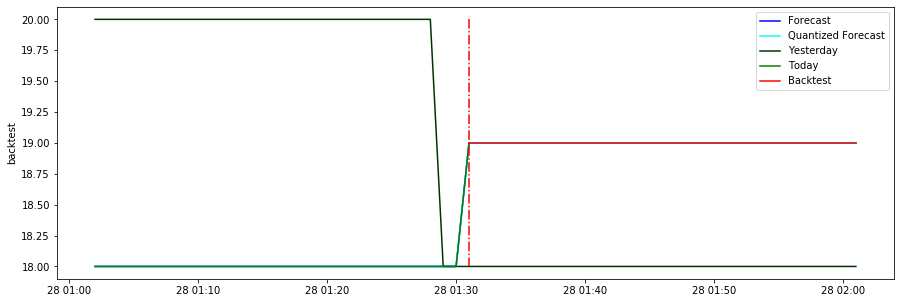

1 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




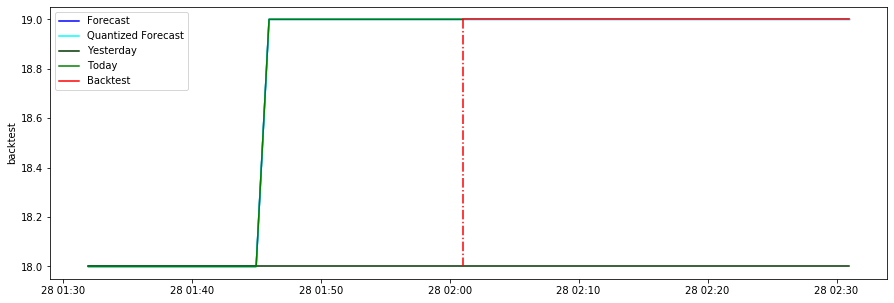

2 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




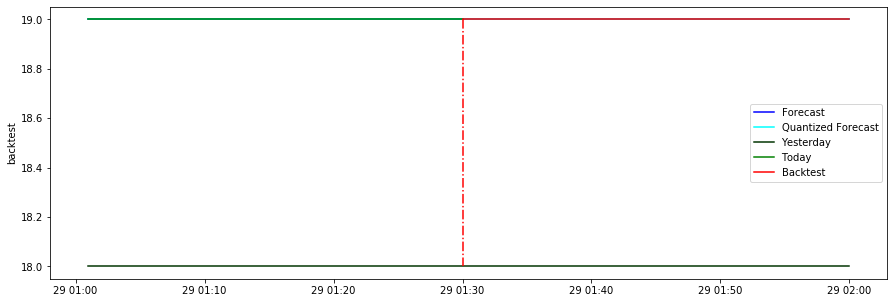

3 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




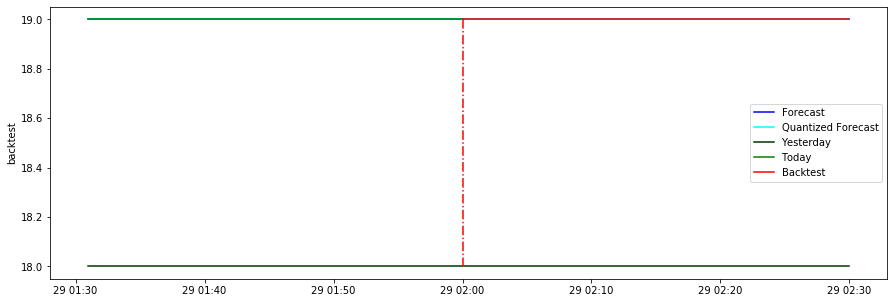

4 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




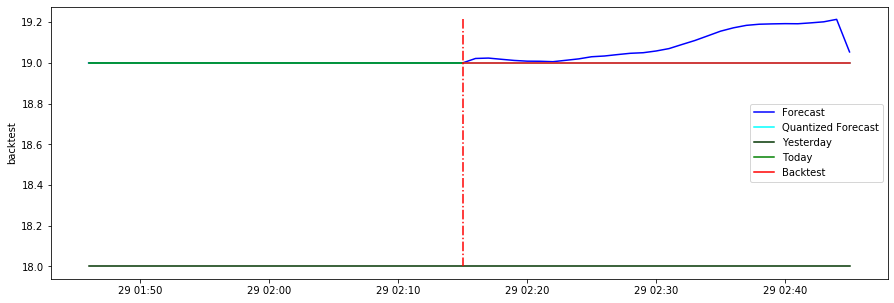

5 / 97
Best parameters: ['add', False, 'mul', 60, False, False]
RMSE: 0.11835463894948599




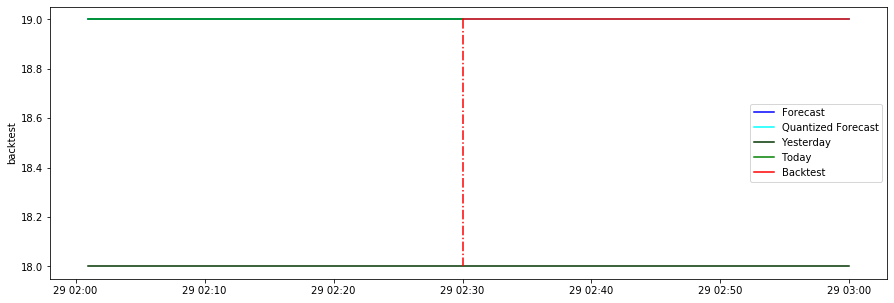

6 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




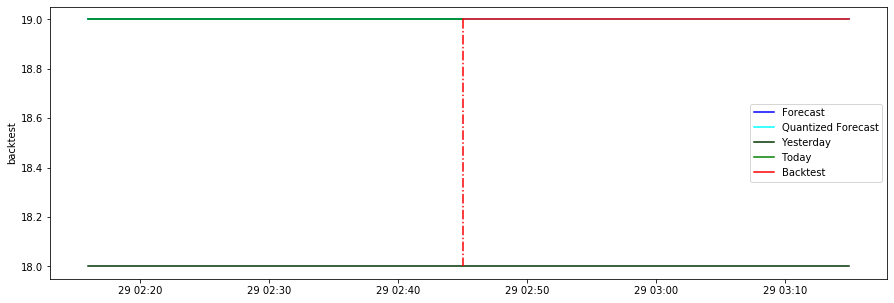

7 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 0.0




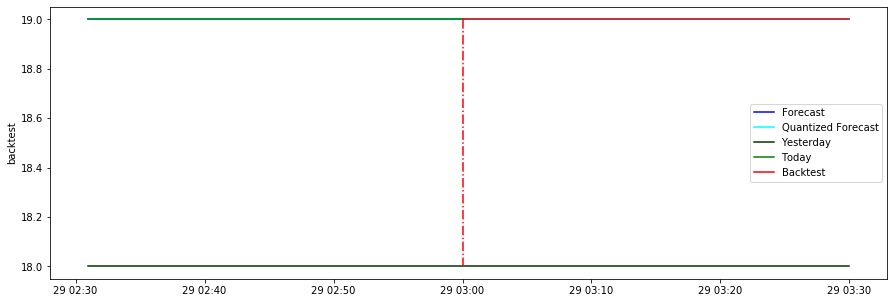

8 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




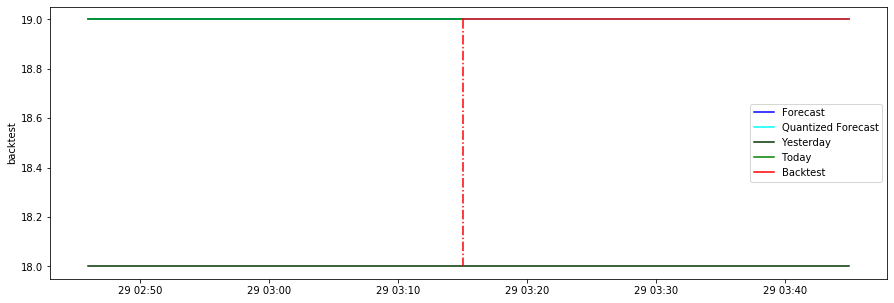

9 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




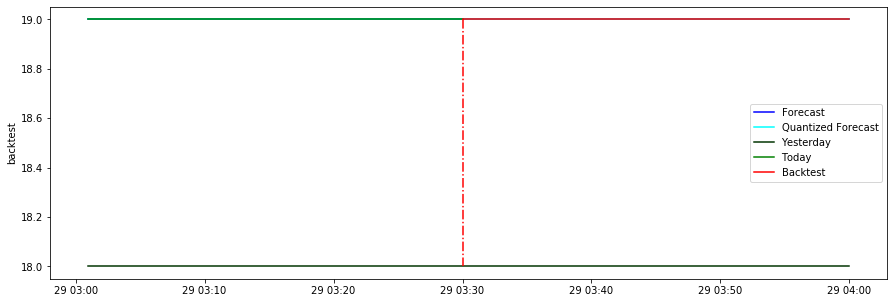

10 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




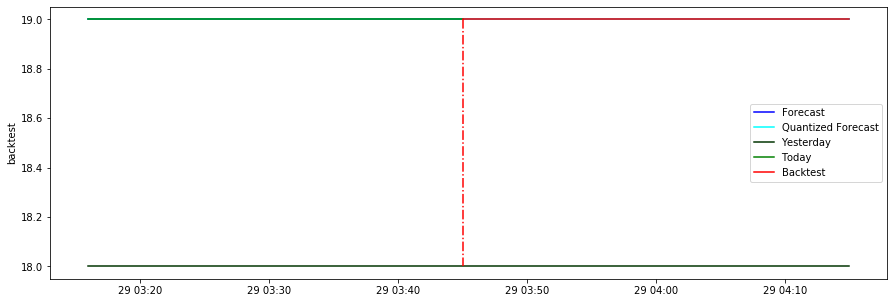

11 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




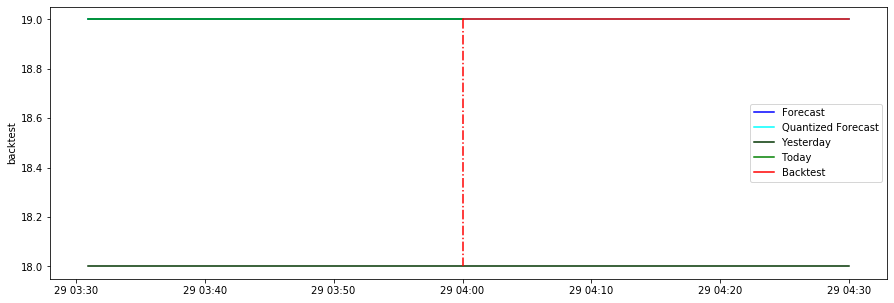

12 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




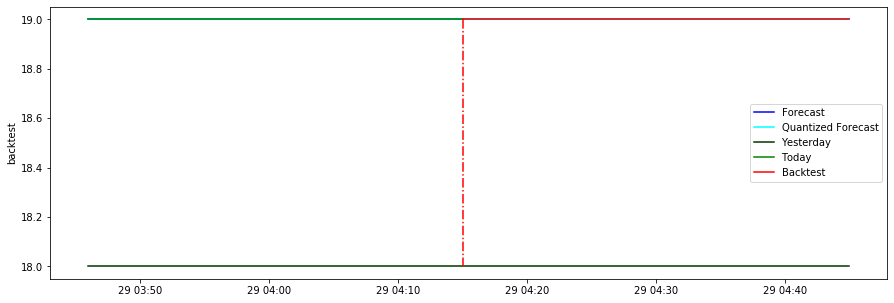

13 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




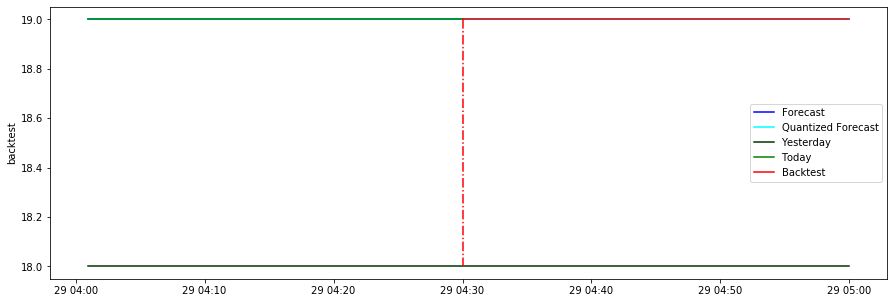

14 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




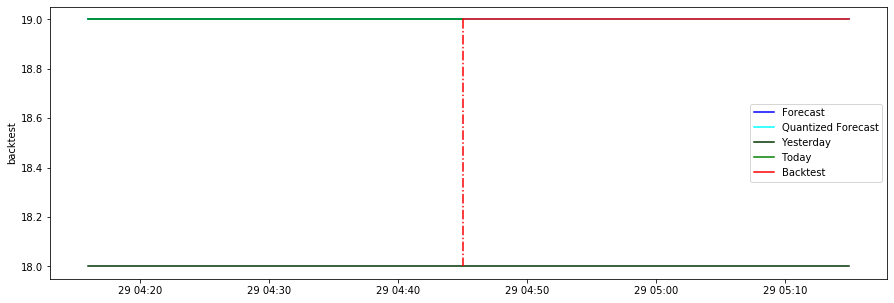

15 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




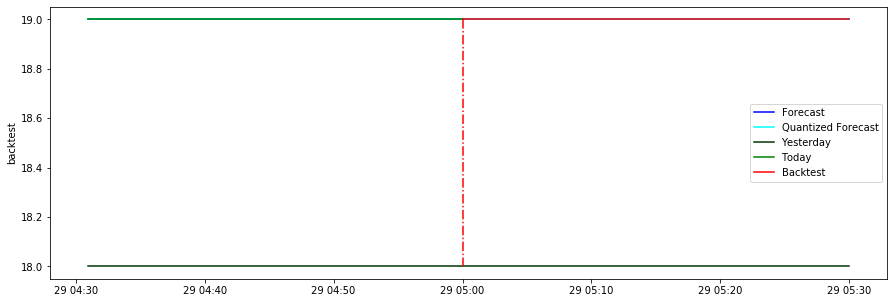

16 / 97
Best parameters: ['add', False, None, 60, True, False]
RMSE: 3.552713678800501e-15




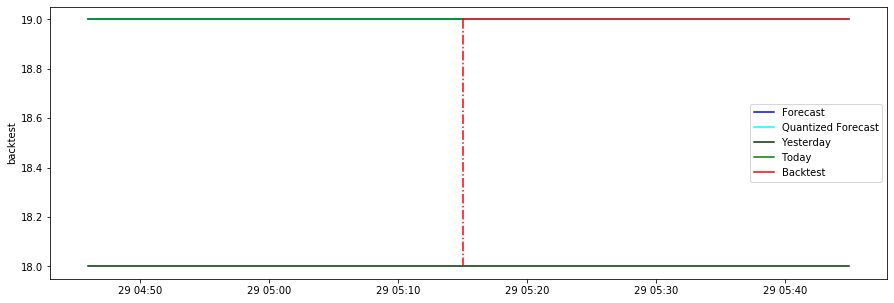

17 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




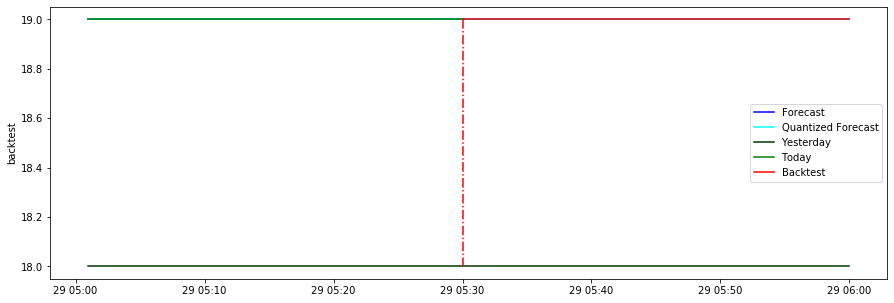

18 / 97
Best parameters: ['mul', True, None, 60, False, False]
RMSE: 0.0




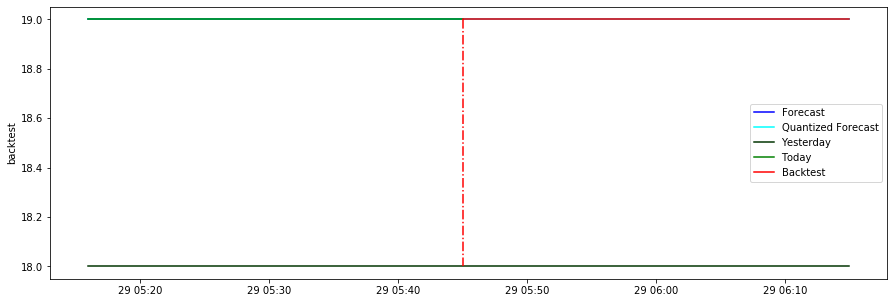

19 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




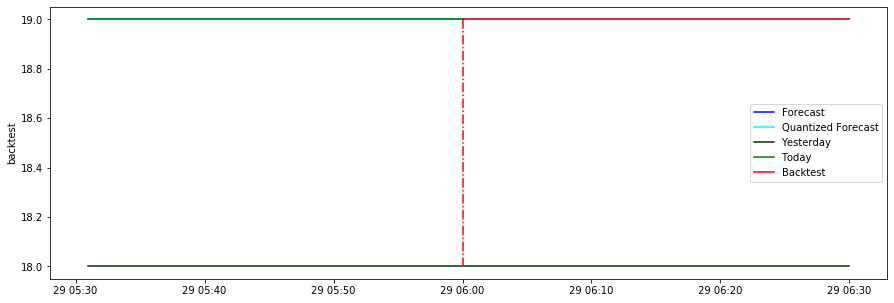

20 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




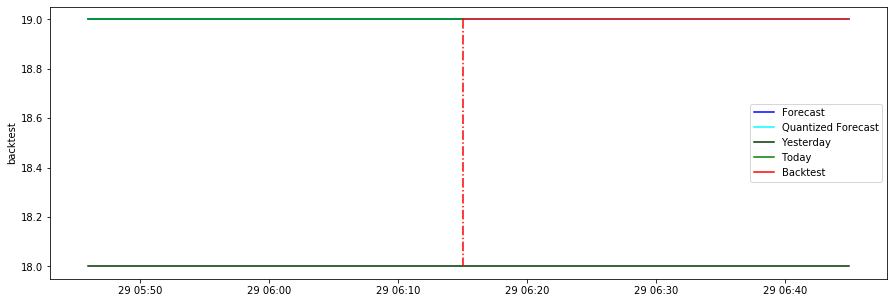

21 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.0




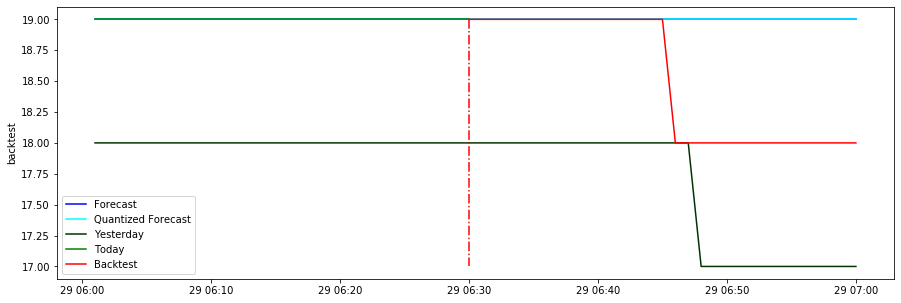

22 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.7071067811865476




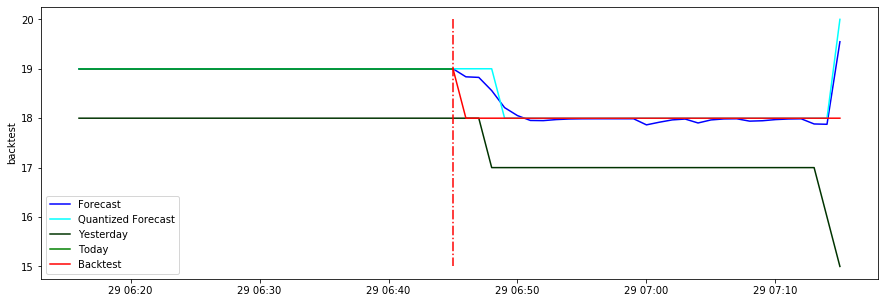

23 / 97
Best parameters: ['add', True, 'add', 60, False, False]
RMSE: 0.37489081906487665




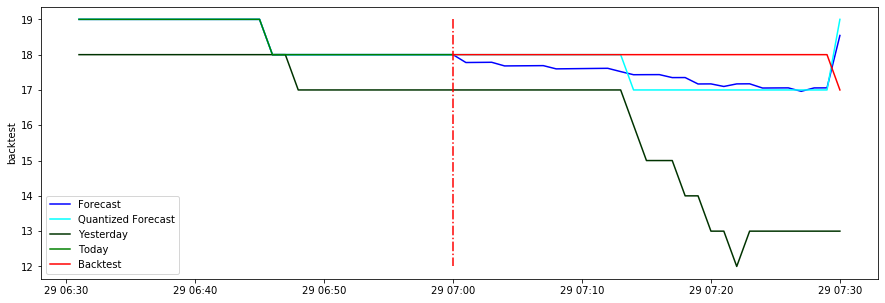

24 / 97
Best parameters: ['add', False, 'mul', 60, False, True]
RMSE: 0.7028546664017312




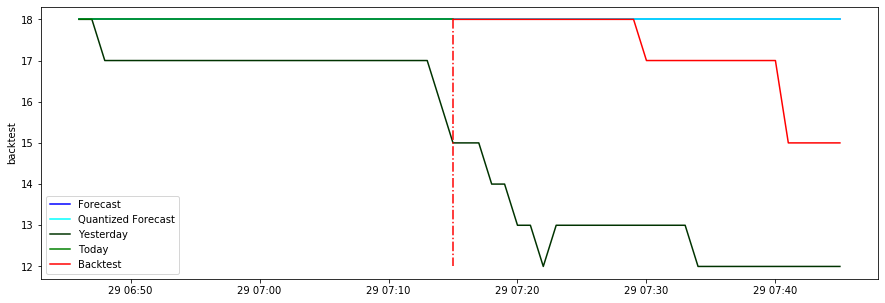

25 / 97
Best parameters: ['mul', True, None, 60, True, False]
RMSE: 1.3662601021279441




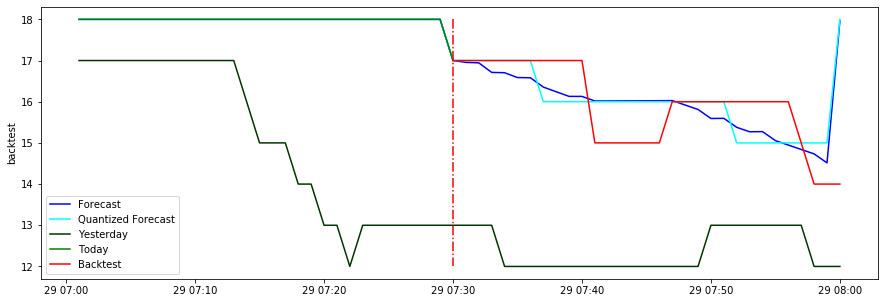

26 / 97
Best parameters: ['add', True, 'add', 60, False, False]
RMSE: 0.9937488302986913




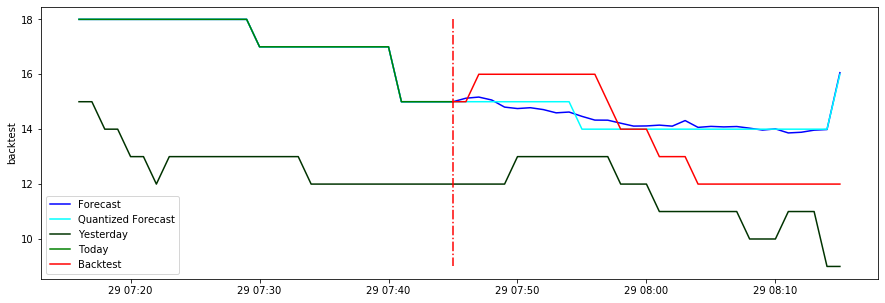

27 / 97
Best parameters: ['add', False, 'mul', 60, True, False]
RMSE: 1.6562427167954439




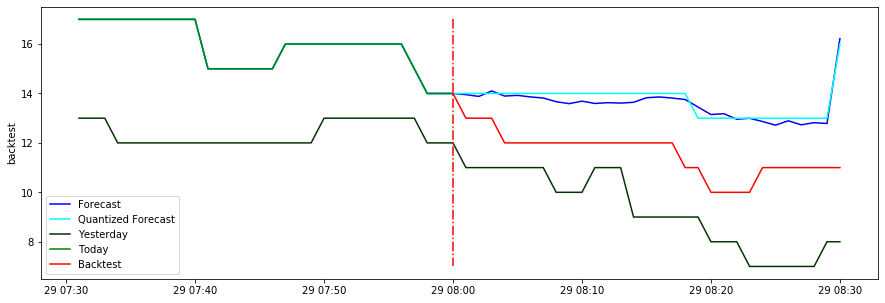

28 / 97
Best parameters: ['add', False, 'mul', 60, False, False]
RMSE: 2.189557802287824




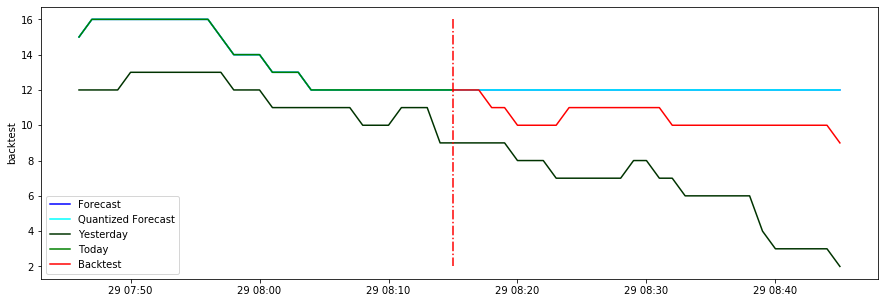

29 / 97
Best parameters: ['add', True, None, 60, True, False]
RMSE: 1.70293863659264




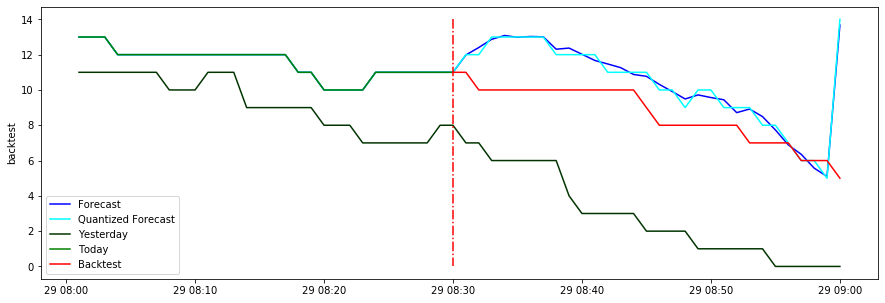

30 / 97
Best parameters: [None, False, 'add', 60, False, False]
RMSE: 2.4439681490935725




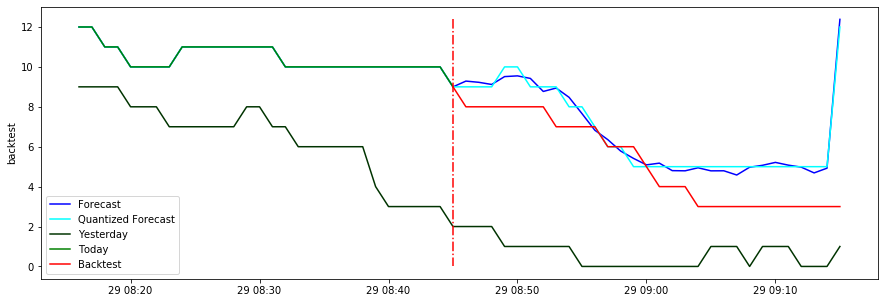

31 / 97
Best parameters: [None, False, 'add', 60, False, False]
RMSE: 2.2350886542465127




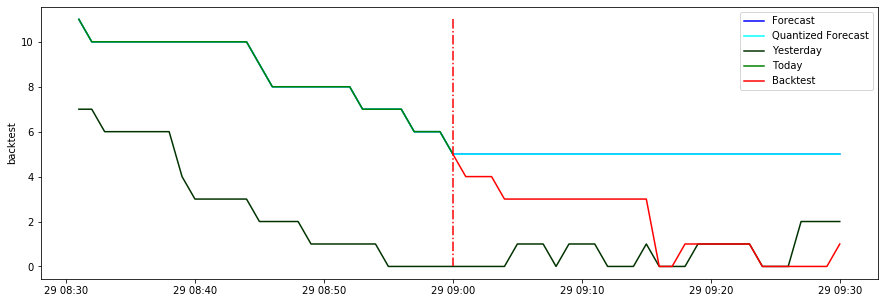

32 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 3.478505426185217




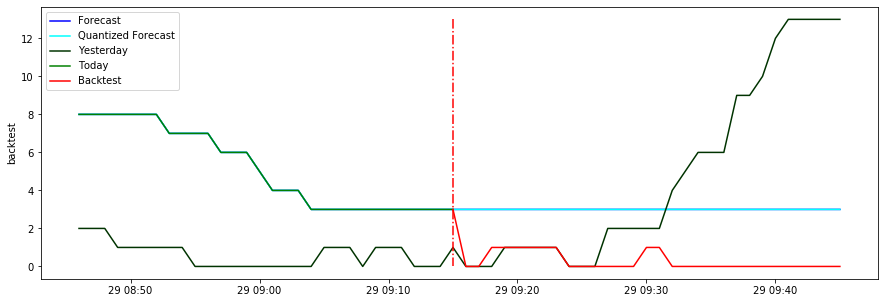

33 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 2.768598901789514




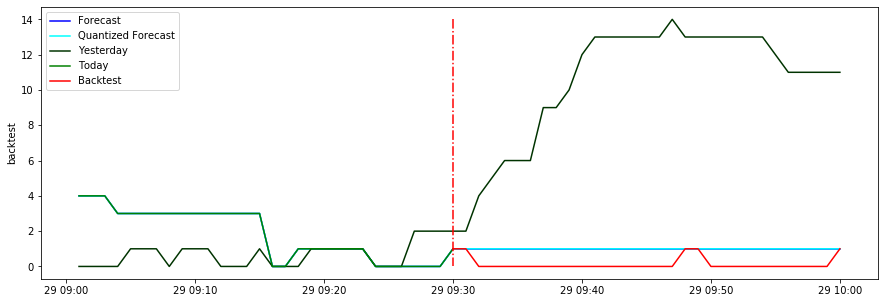

34 / 97
Best parameters: ['add', True, None, 60, False, True]
RMSE: 0.922450771280623




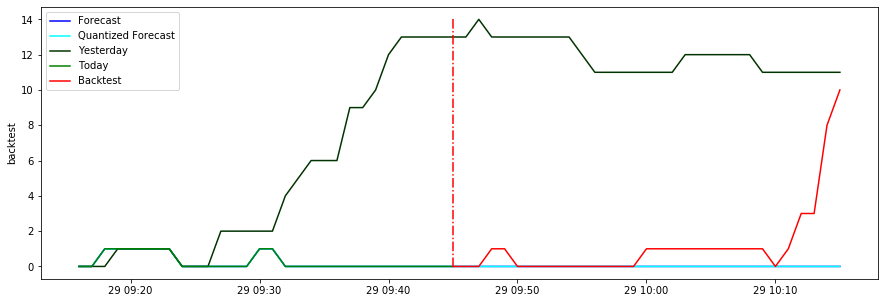

35 / 97
Best parameters: [None, False, None, 60, False, False]
RMSE: 2.5495097567963922




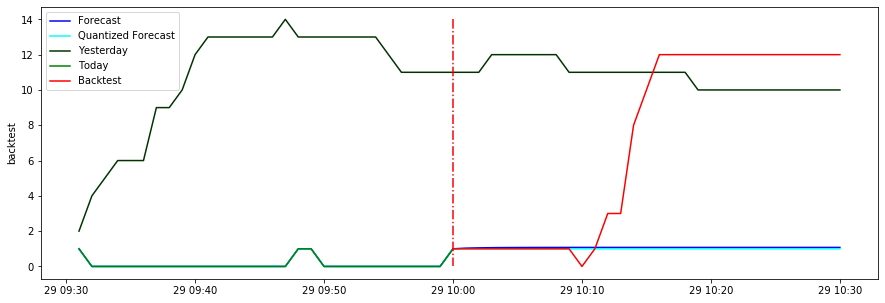

36 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 8.011330505018535




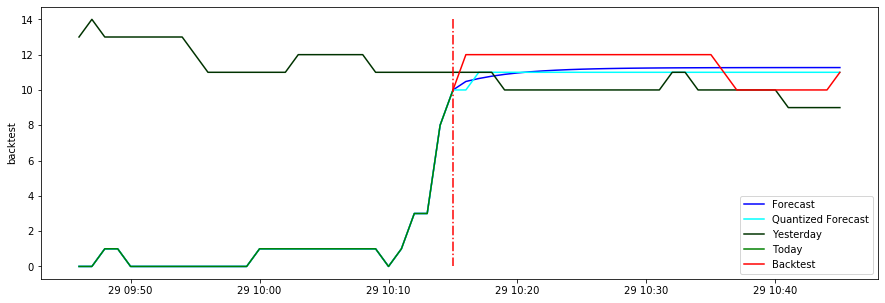

37 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 1.0114222092835958




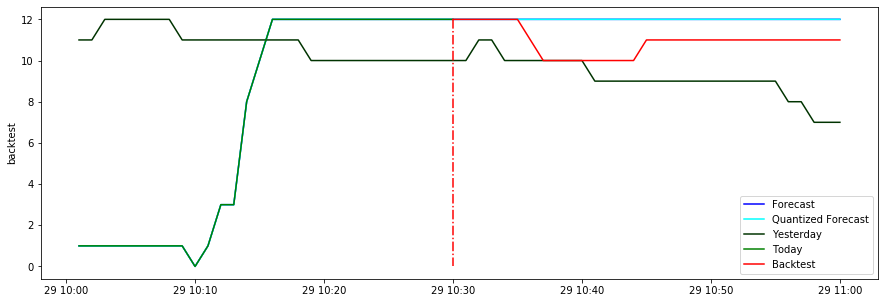

38 / 97
Best parameters: [None, False, None, 60, False, False]
RMSE: 1.2780193008453875




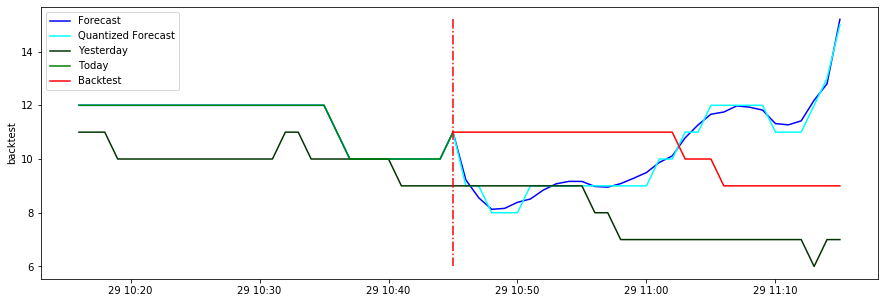

39 / 97
Best parameters: ['add', False, 'add', 60, False, False]
RMSE: 2.5179610034114956




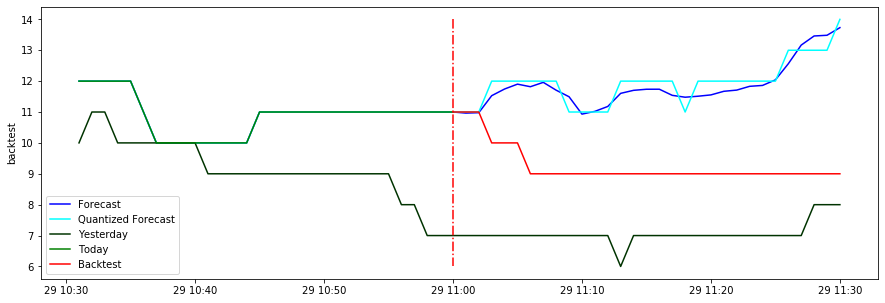

40 / 97
Best parameters: [None, False, 'add', 60, False, True]
RMSE: 2.820829131385666




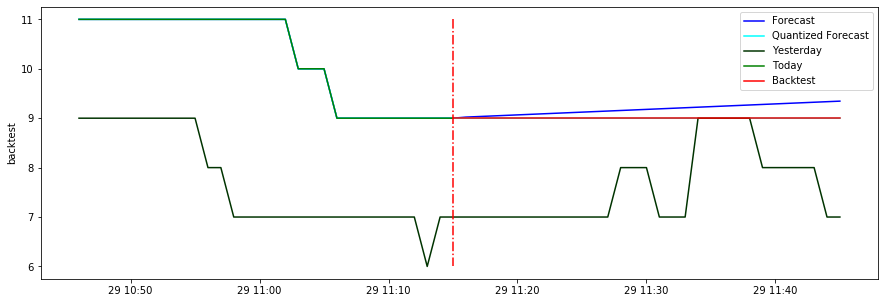

41 / 97
Best parameters: ['add', False, None, 60, False, True]
RMSE: 0.2073497407260134




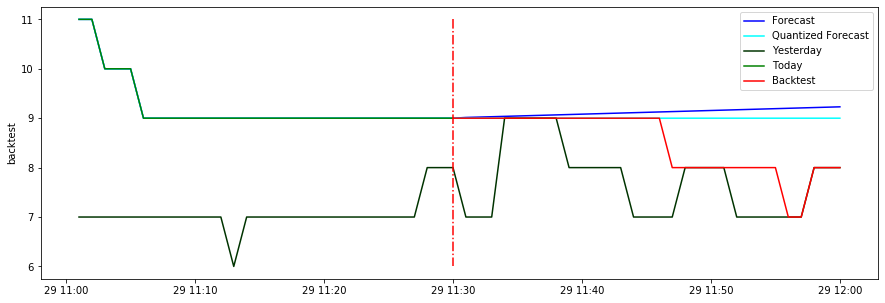

42 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.9394631660404712




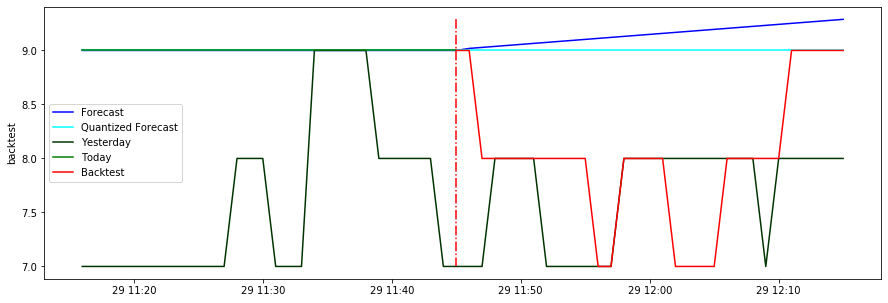

43 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 1.3074509507992493




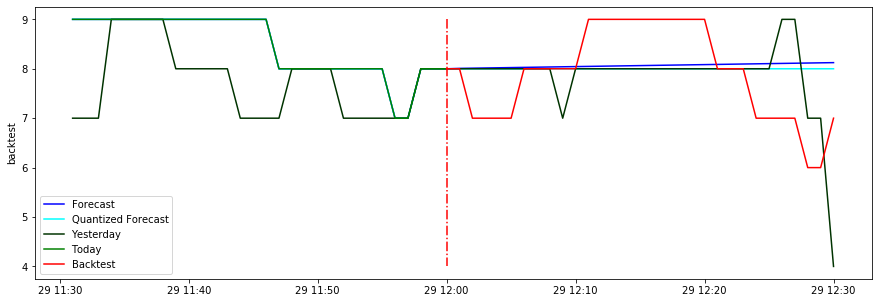

44 / 97
Best parameters: ['add', False, None, 60, False, True]
RMSE: 0.9666660799670069




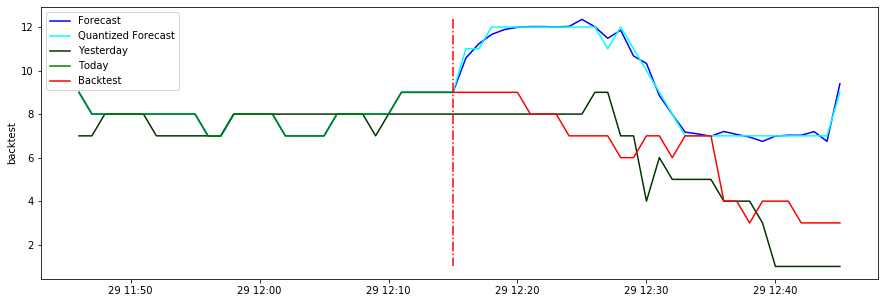

45 / 97
Best parameters: [None, False, 'add', 60, False, False]
RMSE: 3.667097535542114




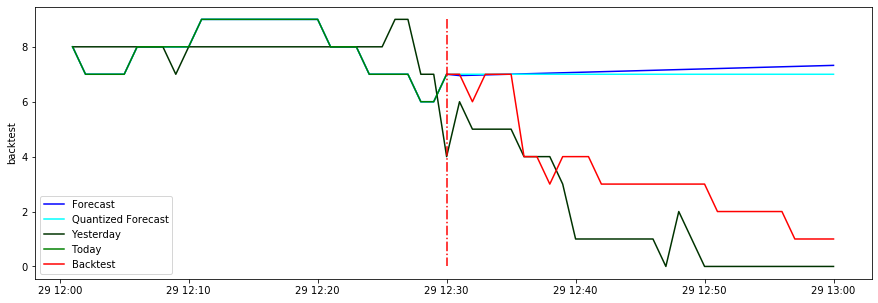

46 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 4.251069012447059




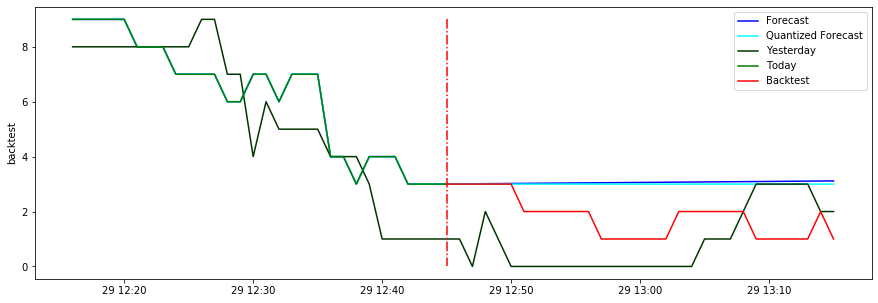

47 / 97
Best parameters: ['add', False, None, 60, False, True]
RMSE: 1.4898706450208998




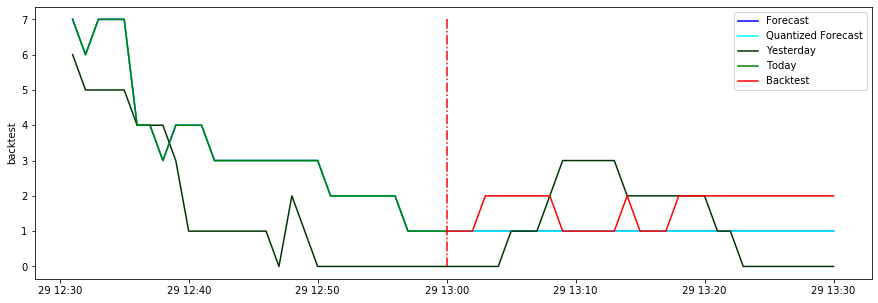

48 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 0.8164954576626762




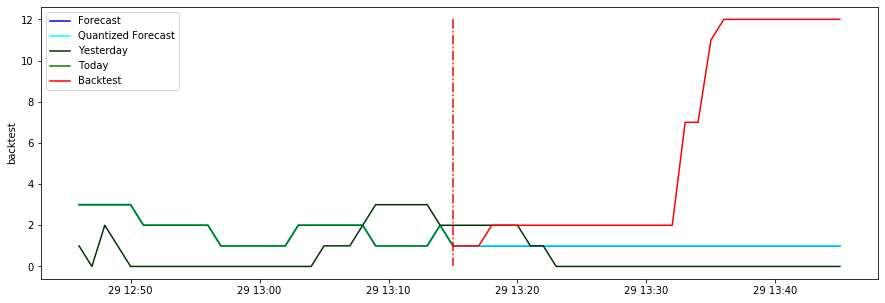

49 / 97
Best parameters: ['add', False, None, 60, False, True]
RMSE: 6.8306290443332855




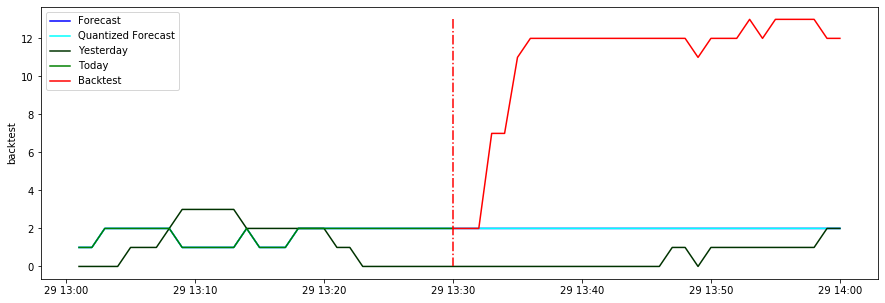

50 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 9.516652072376433




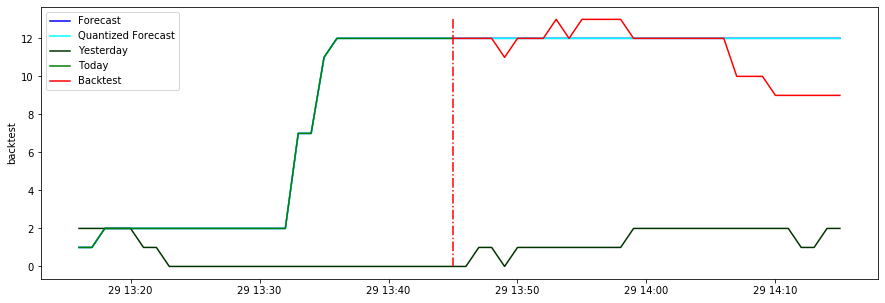

51 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 1.549599430550953




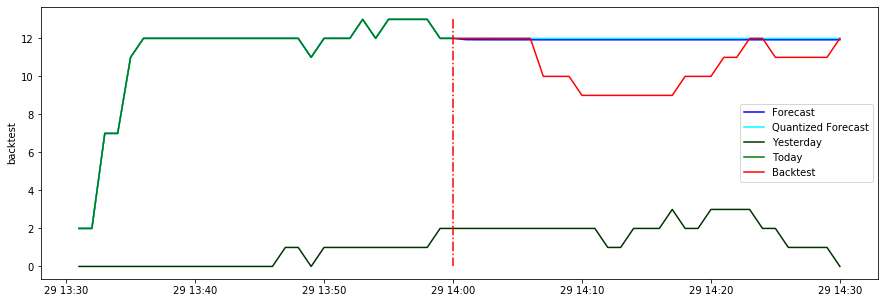

52 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 1.7955617925831362




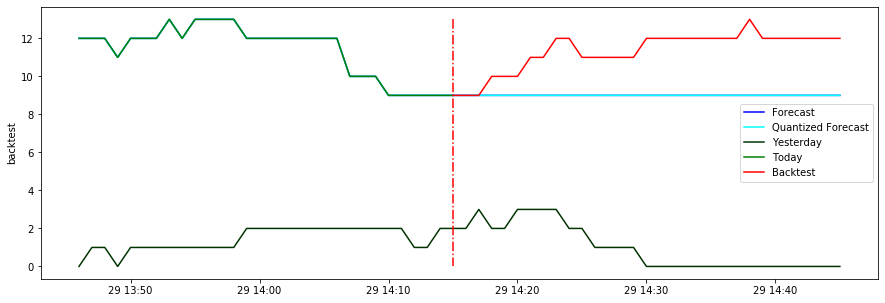

53 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 2.581987620570043




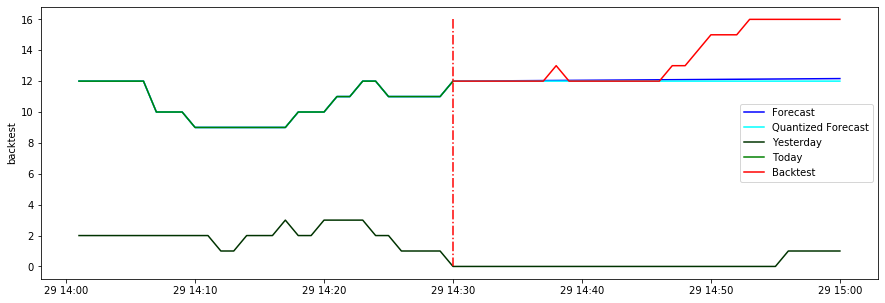

54 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 2.2362882854739135




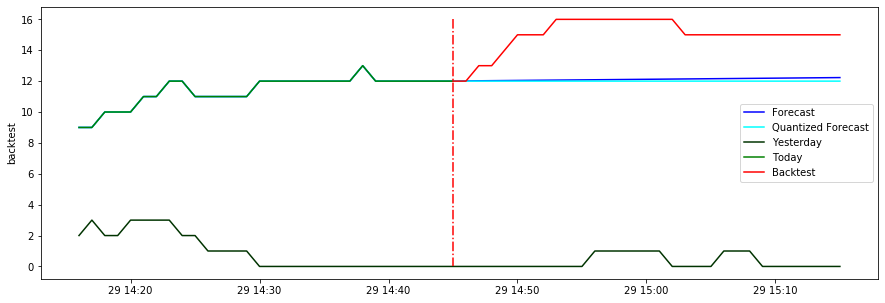

55 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 3.0926399947918273




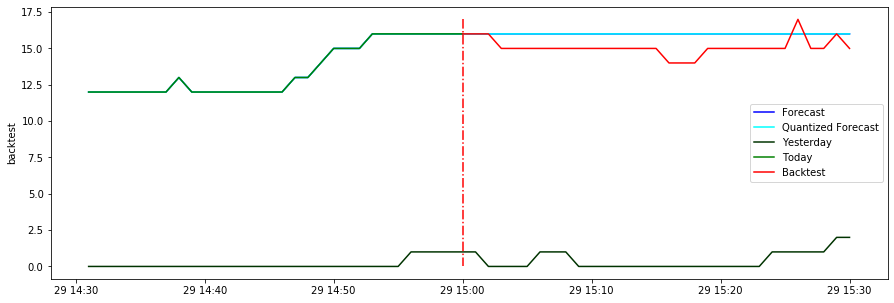

56 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 1.0955736660705873




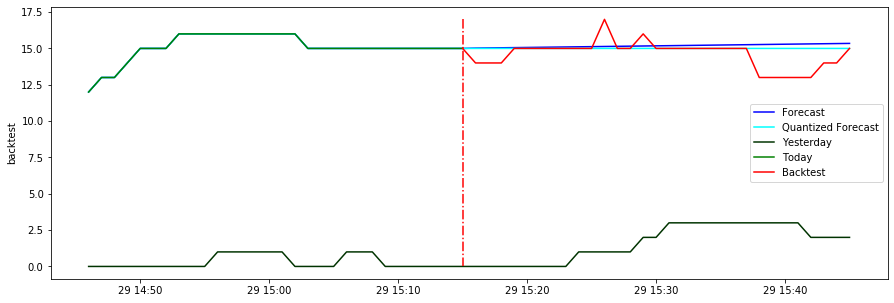

57 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 1.121430646412787




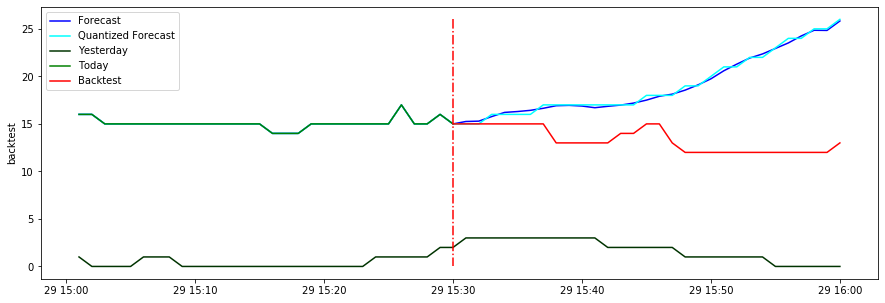

58 / 97
Best parameters: ['add', False, 'add', 60, False, False]
RMSE: 7.209517025008726




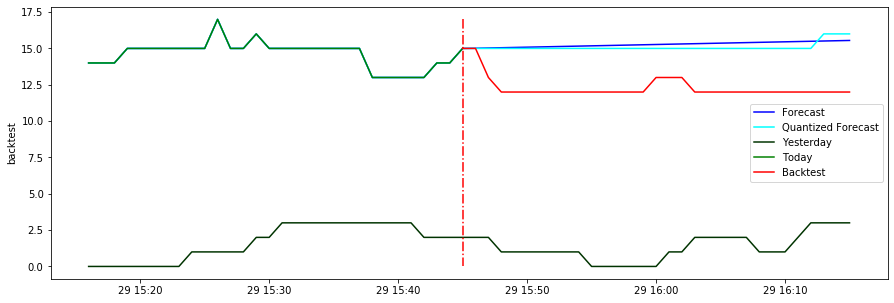

59 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 3.1227981184758566




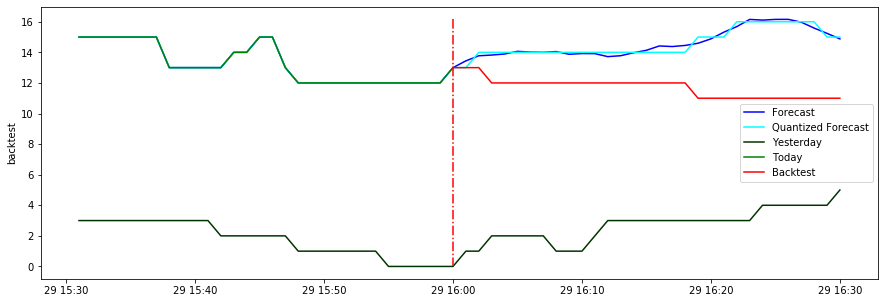

60 / 97
Best parameters: ['add', True, 'add', 60, False, False]
RMSE: 3.268032831019729




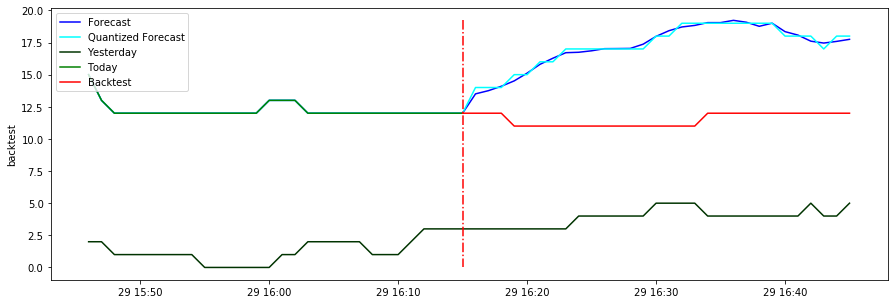

61 / 97
Best parameters: ['add', False, 'add', 60, False, False]
RMSE: 5.953077368956338




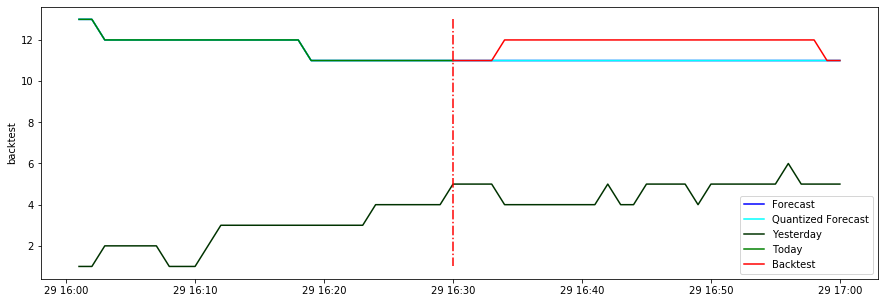

62 / 97
Best parameters: ['mul', True, None, 60, False, False]
RMSE: 0.9128709291752769




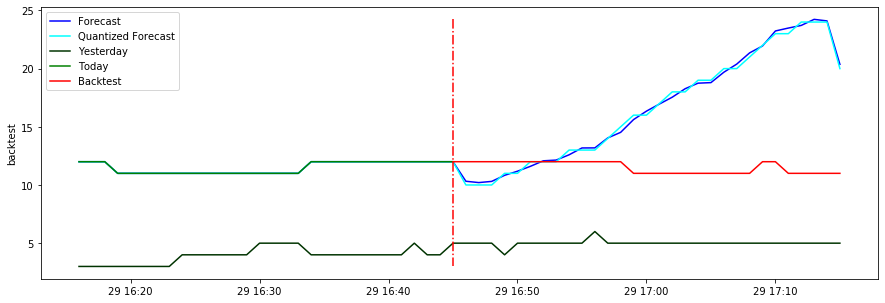

63 / 97
Best parameters: ['mul', False, 'mul', 60, True, False]
RMSE: 7.243780332022765




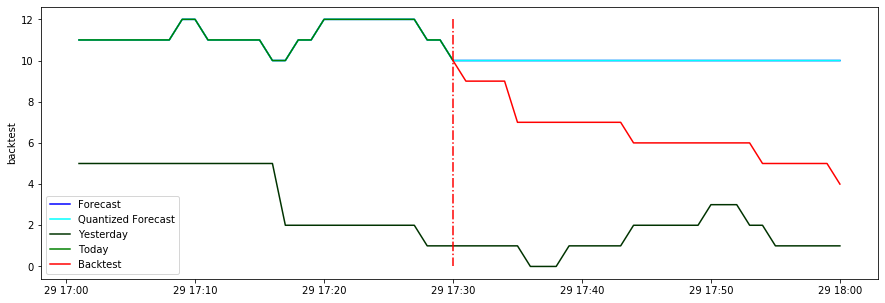

64 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 3.7903385952532878




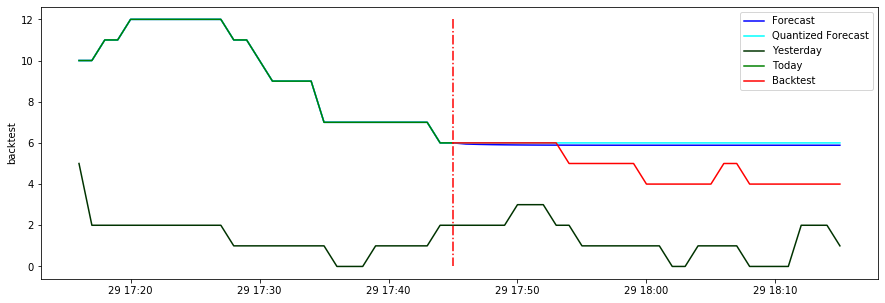

65 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 1.369202127338156




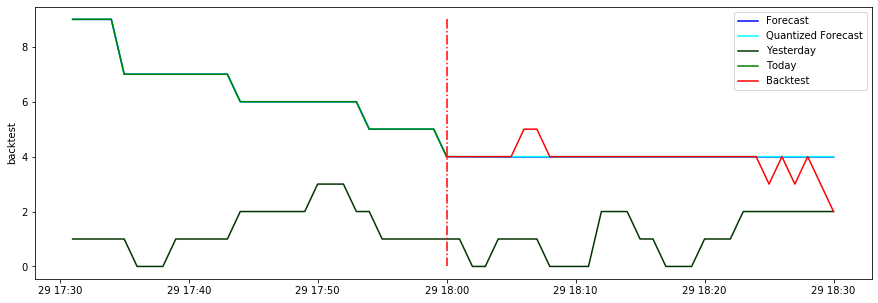

66 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 0.5459432521172622




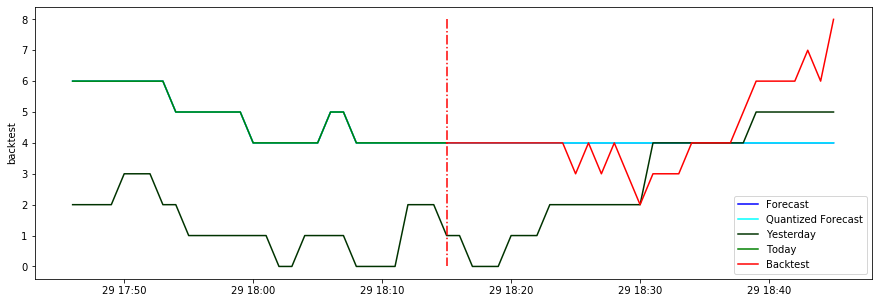

67 / 97
Best parameters: [None, False, None, 60, False, False]
RMSE: 1.3662601021279408




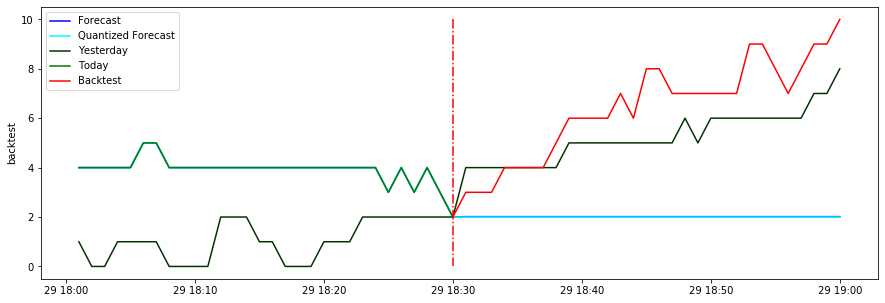

68 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 4.856559012732311




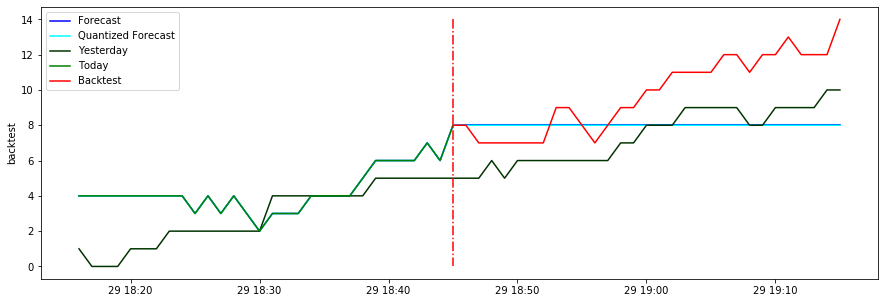

69 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 2.7914719350831563




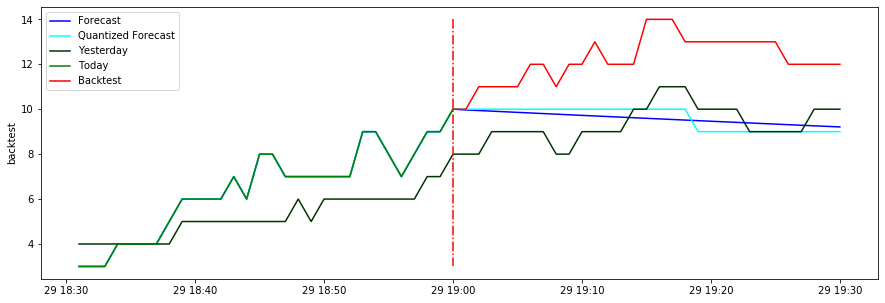

70 / 97
Best parameters: ['mul', False, None, 60, True, True]
RMSE: 2.899454867377303




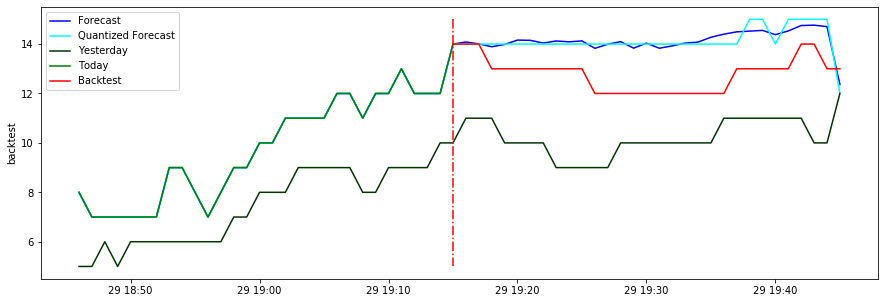

71 / 97
Best parameters: [None, False, 'mul', 60, True, False]
RMSE: 1.5346430509041855




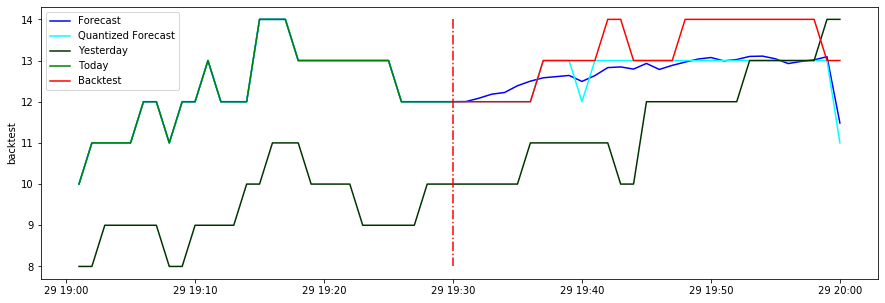

72 / 97
Best parameters: [None, False, 'mul', 60, True, False]
RMSE: 0.752374317773417




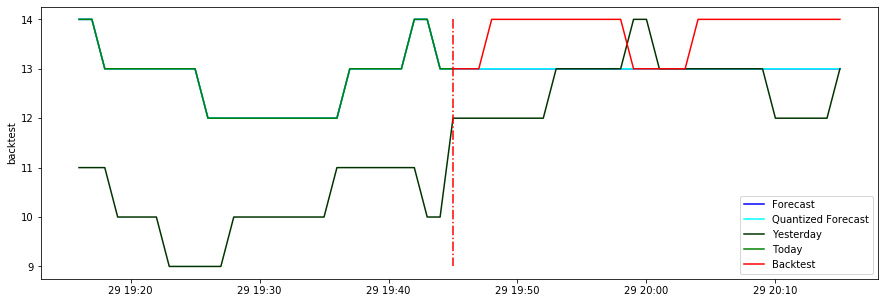

73 / 97
Best parameters: ['add', False, None, 60, True, False]
RMSE: 0.8755017058645099




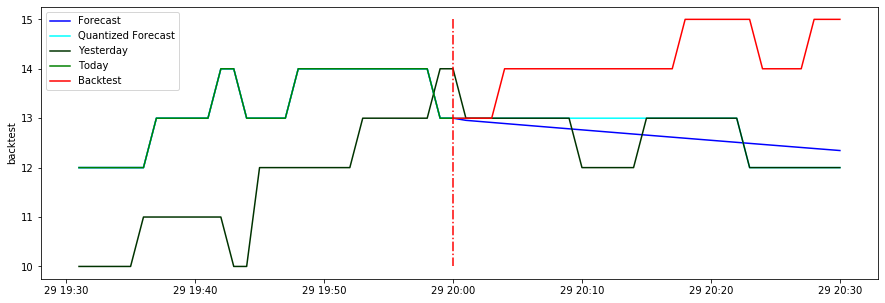

74 / 97
Best parameters: ['mul', False, None, 60, True, False]
RMSE: 1.719284210513086




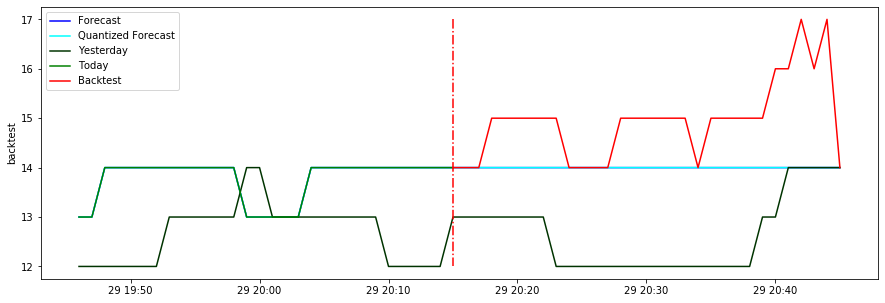

75 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 1.2516655570345794




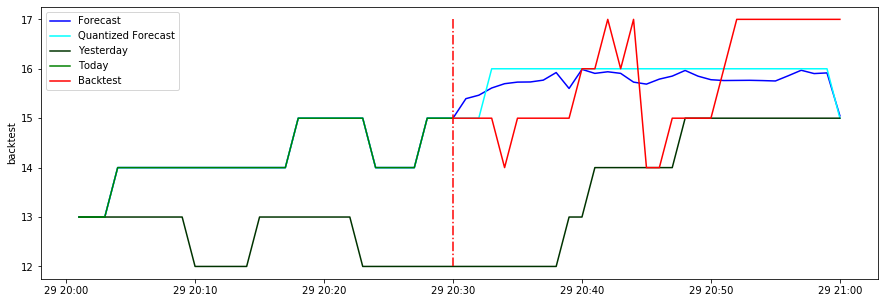

76 / 97
Best parameters: [None, False, 'add', 60, False, False]
RMSE: 1.0497270758451671




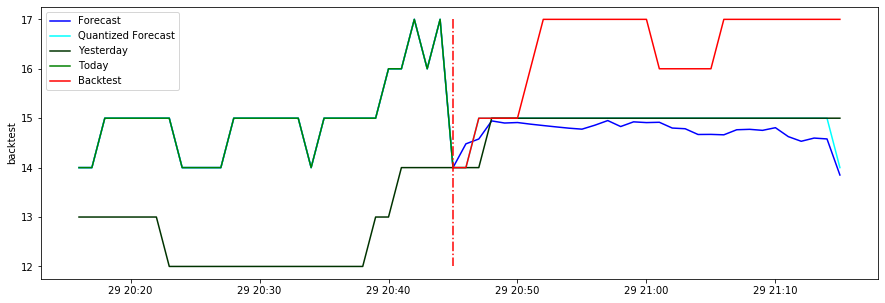

77 / 97
Best parameters: ['mul', False, 'add', 60, False, True]
RMSE: 1.9070934599496698




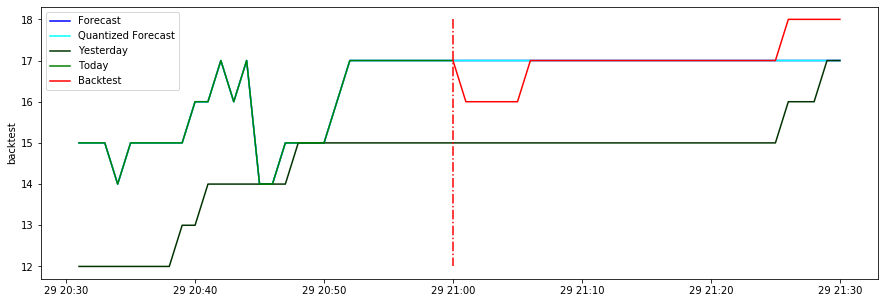

78 / 97
Best parameters: ['mul', True, None, 60, True, False]
RMSE: 0.577324775442277




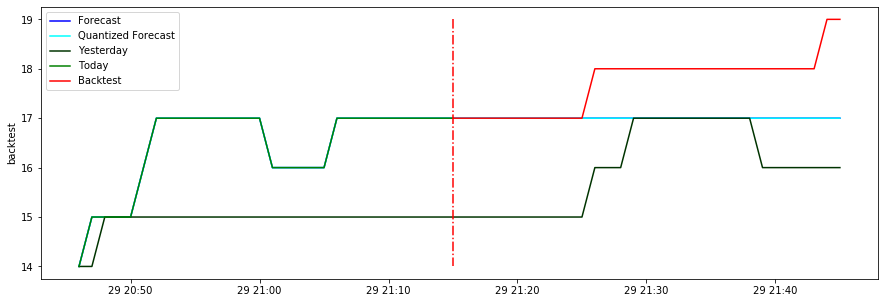

79 / 97
Best parameters: ['add', True, None, 60, True, False]
RMSE: 0.9309493362512627




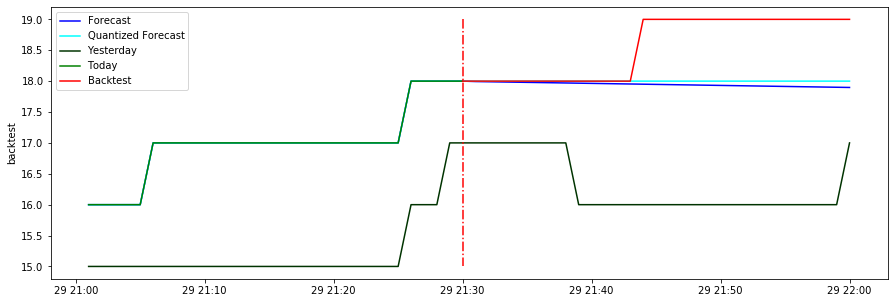

80 / 97
Best parameters: ['mul', False, None, 60, False, False]
RMSE: 0.8103791870335956




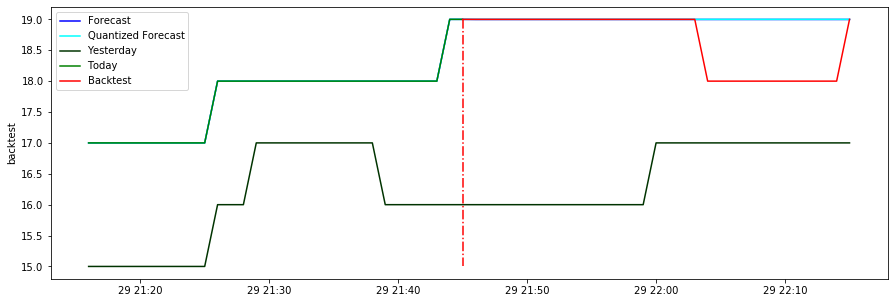

81 / 97
Best parameters: ['mul', True, None, 60, True, False]
RMSE: 0.6044250617973549




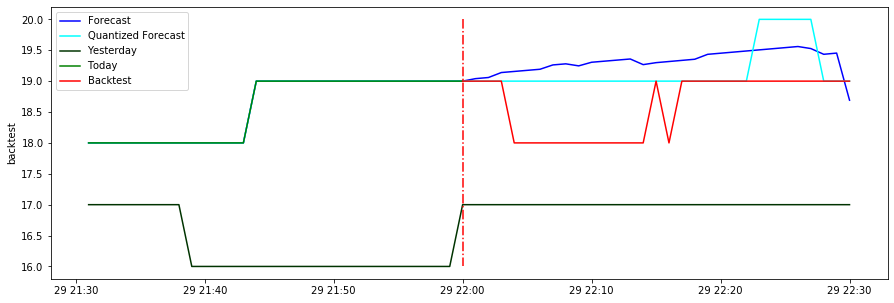

82 / 97
Best parameters: ['add', False, 'mul', 60, True, False]
RMSE: 0.8655172107776697




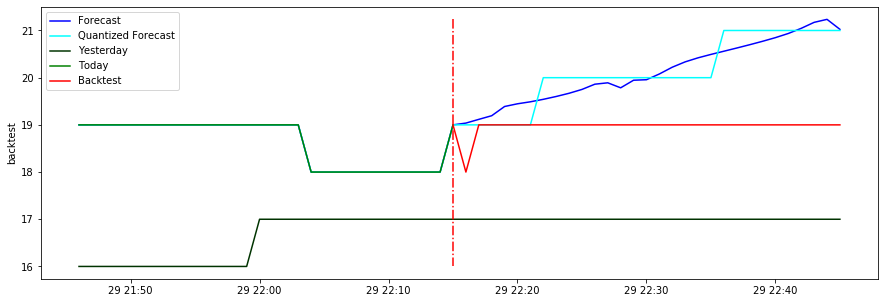

83 / 97
Best parameters: ['mul', False, 'mul', 60, False, False]
RMSE: 1.3205123228139297




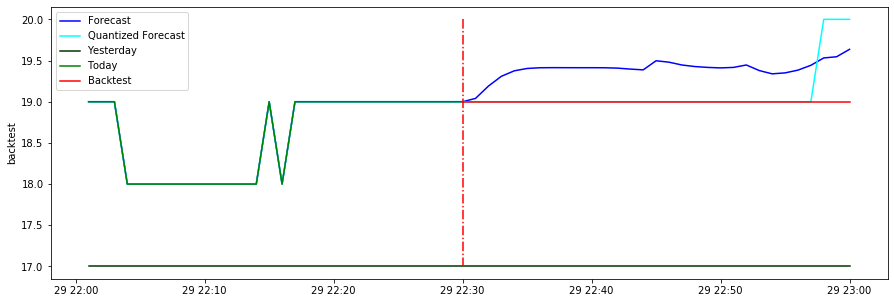

84 / 97
Best parameters: ['add', True, 'add', 60, True, True]
RMSE: 0.41686457387413983




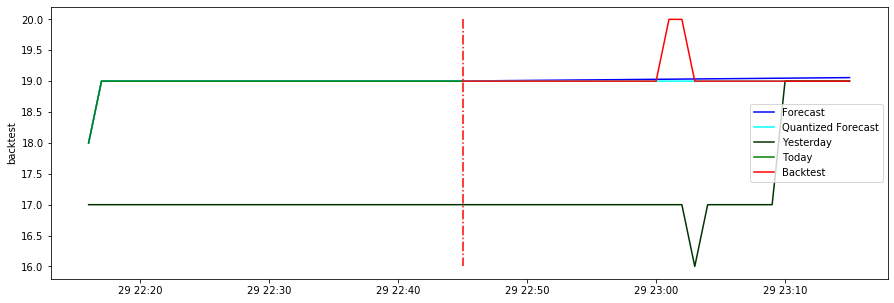

85 / 97
Best parameters: ['add', False, None, 60, True, False]
RMSE: 0.25208128727491097




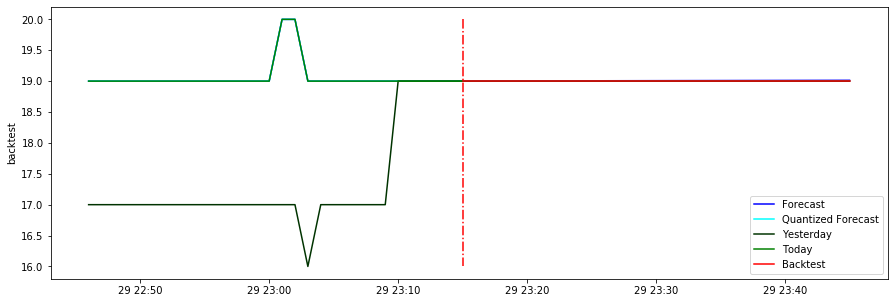

86 / 97
Best parameters: ['mul', False, None, 60, False, True]
RMSE: 0.008470114479905415




In [96]:
# Generating all availiable graphics

for i in range(df_result.shape[0]):
    model_generation_viz(df_result.hour[i], 30, df_result.best_parameters[i])
    print(i+1,"/",len(time_list)+1)
    print("Best parameters:",df_result.best_parameters[i])
    print("RMSE:",df_result.rmse_f_b[i])
    print()
    print()
    

## IV. Exploring the modification of some parameters

In [121]:
def model_generation_detail(time, time_step, best_parameters):

    # I. INITIALIZATION OF THE MODEL
    
    start_time = timeit.default_timer()
    # Timestamp of when we want to start the prediction
    target_start = time
    # n-1 minutes before the target date and n min after
    time_variation = time_step
    # Loading from github the dataset. It is an extract of the madeleine station only
    df_station = pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")

    # II. PREPROCESSING PIPE
    # Removing first not useless column
    df_station.pop("Unnamed: 0")

    # Adding day and minute
    df_station["day"] = df_station.date.apply(lambda x: x[:10])

    # Converting to datetime the number of availiable docks
    df_station['date'] = pd.to_datetime(df_station['date'])

    # Variable declaration

    # list the different days. Removing 2020_01_15 for lack of data.
    day_list = df_station.day.unique()

    #removing first day (incomplete data) and last day (only midnight)
    day_list = day_list[1:-1]

    # Creation of time bounds
    lower_time_bound = str(pd.Timestamp(target_start) - pd.Timedelta(minutes=time_variation))[-8:]
    upper_time_bound = str(pd.Timestamp(target_start) + pd.Timedelta(minutes=time_variation+1))[-8:]

    # proper consolidation
    df_conso = pd.DataFrame(columns=df_station.columns)
    for i in range(len(day_list)-1):

        # The 30 min after the time, the day before

        day_lower = day_list[i]
        df_day_lower = df_station[df_station["day"] == day_lower]
        df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_lower, target_start))
                    & (df_day_lower["date"] < "{} {}".format(day_lower,upper_time_bound))]


        # The 30 min before the time, the day 


        day_upper = day_list[i+1]
        df_day_upper = df_station[df_station["day"] == day_upper]
        df_day_upper = df_day_upper[(df_day_upper["date"] > "{} {}".format(day_upper, lower_time_bound))
                    & (df_day_upper["date"] <= "{} {}".format(day_upper,target_start))]

        df_conso = pd.concat([df_conso, df_day_lower, df_day_upper])

    # Backtest for ulterior use
    day_backtest = day_list[len(day_list)-1]
    df_day_lower = df_station[df_station["day"] == day_backtest]
    df_day_lower = df_day_lower[(df_day_lower["date"] > "{} {}".format(day_backtest, target_start))
                & (df_day_lower["date"] < "{} {}".format(day_backtest,upper_time_bound))]["availiable_docks"]
    df_backtest = np.array(df_day_lower)



    df_conso = df_conso.reset_index(drop="True")

    # Converting to int the number of availiable docks
    df_conso["availiable_docks"] = df_conso["availiable_docks"].astype(int)
    df_conso.head()

    # Creating time_serie
    time_serie = np.array(df_conso["availiable_docks"])

    # Doing a slit of aust between train and test
    split_ratio = 1- 1/(len(time_serie)/(time_variation*2))
    train = time_serie[0:int(round(len(time_serie)*split_ratio,0))]
    test = time_serie[int(round(len(time_serie)*split_ratio,0)):]


    # This will be our performance indicator
    
    # Loading the best parameters found befor
    t,d,s,p,b,r = best_parameters


    # C. Training on full time serie to optimize before prediction¶

    # Creating the model on full time serie, using best parameters
    model = ExponentialSmoothing(time_serie, trend=t, damped=d, seasonal=s, seasonal_periods=p).fit(optimized=True,use_boxcox=b,remove_bias=r)

    # predicting on all time serie for global RMSE
    pred_model = model.predict(1,end=len(time_serie))
    RMSE_test = measure_rmse(time_serie,pred_model)


    # Prediction the dataset + time variation
    final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))


    # IV - Making the prediction up to the time variation and creating assessment dataframe

    # Prediction the dataset + time variation
    final_prediction = model.predict(start=(len(time_serie)+1), end=(len(time_serie)+time_variation))


    # Creating a dataframe for assessement
    df_assessement = pd.DataFrame(columns=["actual","forecast_optimized","forecast_optimized_round","backtest"])
    # Setting actual at the last known value
    df_assessement.actual = (np.concatenate((time_serie, (np.zeros(time_variation)+time_serie[-1:])), axis = 0))
    # Setting forecast at time_serie for the past and the final prediction for the futur
    df_assessement.forecast_optimized = (np.concatenate((time_serie, final_prediction), axis = 0))
    df_assessement.forecast_optimized_round = df_assessement.forecast_optimized.apply(lambda x:round(x,0))
    df_assessement.backtest = (np.concatenate((time_serie, df_backtest), axis = 0))
    df_assessement["date"] = df_conso["date"]
    df_assessement.head()
    # Making a synthetic dataset for easier visualisation

    # Making a synthetic dataset for easier visualisation

    df_assessement_small = df_assessement[-time_variation*2:]
    start_date = pd.Timestamp(np.array(df_assessement_small["date"])[0])
    end_date = start_date + pd.Timedelta(minutes=time_variation*2-1)

    index_date = pd.date_range(start=start_date, end=end_date, freq="T")
    df_assessement_small.index = index_date
    df_assessement_small.pop("date")
    df_assessement_small["day_before"] = np.array(df_assessement[-time_variation*4:-time_variation*2]["actual"])
    df_assessement_small.head()
    
 #   lower_bound, upper_bound = upper_lower_bounds(df_assessement_small)
    
    # V. SYNTHSIS
    
    # Graphic visualisation of the prediction

# Setting prediction boundary
    # Calculating lower and upper bounds for ulterior use

# Calculating lower and upper bounds for ulterior use


    #Removing actual and backtest data on projection time for better visualisation
    df_assessement_small.actual[-time_variation:] = None
    df_assessement_small.backtest[:-time_variation-1] = None

    # Graphic visualisation of the prediction

    # Time to run

    elapsed = timeit.default_timer() - start_time


    # RMSE for assessement

    rmse_f_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized[time_variation:])
    rmse_rf_b = measure_rmse(df_backtest,df_assessement_small.forecast_optimized_round[time_variation:])
    #reminder of best parameters

    results = [str(target_start)[-8:], rmse_f_b, rmse_rf_b, RMSE_test, best_parameters]
    return results

# Function that return the minimum and maximum value of a dataframe

def upper_lower_bounds(dataframe):
    min_value = 999
    max_value= 0
    for i in dataframe.columns:
        temp_list = np.array(dataframe[i])
        temp_list = temp_list[temp_list >= 0]
        min_temp = np.amin(temp_list)
        max_temp = np.amax(temp_list)
        if min_temp < min_value:
            min_value=min_temp
        if max_temp > max_value:
            max_value = max_temp
    return(max_value, min_value)

In [123]:
# Exemple at hour 28 (9:30) at the effect of changing the config

for i in range(len(config)):
    try:
        print(i)
        print(model_generation_detail(df_result.hour[28], 30, config[i]))
    except:
        pass

0
['08:15:00', 4.211555308581473, 4.234776656841932, 0.8169541650700725, ['add', True, 'add', 60, True, True]]
1
['08:15:00', 4.1987405416645025, 4.234776656841932, 0.8171361410670468, ['add', True, 'add', 60, True, False]]
2
['08:15:00', 4.154730733338178, 4.110960958218893, 0.7707280802512922, ['add', True, 'add', 60, False, True]]
3
['08:15:00', 4.15619868303849, 4.110960958218893, 0.7707210595080012, ['add', True, 'add', 60, False, False]]
4
['08:15:00', 4.12120717235656, 4.0041644987854, 0.7371670826957875, ['add', True, 'mul', 60, True, True]]
5
['08:15:00', 4.12491033216807, 4.0041644987854, 0.7371574076723264, ['add', True, 'mul', 60, True, False]]
6
['08:15:00', 4.184543686614096, 4.183300132670378, 0.7665958791176418, ['add', True, 'mul', 60, False, True]]
7
['08:15:00', 4.1892163364009765, 4.183300132670378, 0.7665951744573021, ['add', True, 'mul', 60, False, False]]
8
['08:15:00', 4.211555308581473, 4.234776656841932, 0.8169541650700725, ['add', True, 'additive', 60, True, 

['08:15:00', 4.15619868303849, 4.110960958218893, 0.7707210595080012, ['additive', True, 'additive', 60, False, False]]
76
['08:15:00', 1.6952467244537113, 1.70293863659264, 0.02279514762244513, ['additive', True, None, 60, True, True]]
77
['08:15:00', 1.70293863659264, 1.70293863659264, 0.020849115465890106, ['additive', True, None, 60, True, False]]
78
['08:15:00', 1.694518879819028, 1.70293863659264, 0.01582956950592601, ['additive', True, None, 60, False, True]]
79
['08:15:00', 1.70293863659264, 1.70293863659264, 0.012839452311104085, ['additive', True, None, 60, False, False]]
80
['08:15:00', 4.146115591324538, 4.258325179379017, 0.8626825807976205, ['additive', False, 'add', 60, True, True]]
81
['08:15:00', 4.139332157774442, 4.258325179379017, 0.8627559379958787, ['additive', False, 'add', 60, True, False]]
82
['08:15:00', 4.532689876513344, 4.54972526643093, 0.799162363415744, ['additive', False, 'add', 60, False, True]]
83
['08:15:00', 4.567268191869727, 4.611579628139003, 0.7

It comes difficult to find a way to improve the model by limiting the parameters

## V. Analysis of the model 

### A. Analysis of the Distribution

In [231]:
df_rmse = pd.DataFrame(index=df_result.hour, data= np.array(df_result["rmse_f_b"]), columns=["RMSE forecast vs backtest"])

#### 1. Outliers

In [182]:
df_rmse.describe()

,RMSE forecast vs backtest
count,86.000000
mean,1.668856
std,1.987917
min,0.000000
25%,0.140603
50%,1.030575
75%,2.392048
max,9.516652


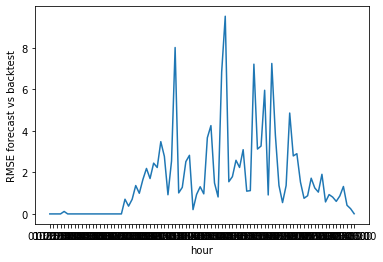

In [179]:
_ = sns.lineplot(data=df_rmse, x=df_rmse.index, y="RMSE forecast vs backtest")

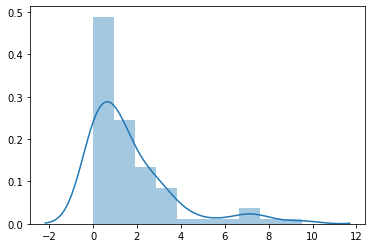

In [185]:
_ = sns.distplot(df_rmse)

We can see here that the model works pretty well, having a mean at 1,6 and a mediana t 1. The 3rd quantile is at 2, which is honorable. But the max is really important: 9,5! It tseems there are very few outliers.

In [188]:
df_rmse[df_rmse["RMSE forecast vs backtest"]>4].count()

RMSE forecast vs backtest    8
dtype: int64

Only 8 values are superior to 4

In [189]:
df_rmse[df_rmse["RMSE forecast vs backtest"]>4]

,RMSE forecast vs backtest
hour,
10:00:00,8.011331
12:30:00,4.251069
13:15:00,6.830629
13:30:00,9.516652
15:30:00,7.209517
16:15:00,5.953077
16:45:00,7.243780
18:30:00,4.856559


#### 2. Zero Values

In [202]:
df_rmse[df_rmse["RMSE forecast vs backtest"]==0]

,RMSE forecast vs backtest
hour,
01:00:00,0.0
01:15:00,0.0
01:30:00,0.0
02:00:00,0.0
02:30:00,0.0
02:45:00,0.0
03:00:00,0.0
03:15:00,0.0
03:30:00,0.0


In [200]:
df_rmse[df_rmse["RMSE forecast vs backtest"]==0].count()

RMSE forecast vs backtest    19
dtype: int64

There are 19 values at zero, and it is before 6:15. The station has no activity! We must remove them in order not to improve the global RMSE

### B. Analysis of the outliers

For 10:00 and 13h15/13h30, RMSE is important due to the van coming to take away some bikes. This is an unexpected event and does not reflect an efficiency in the algorithm.

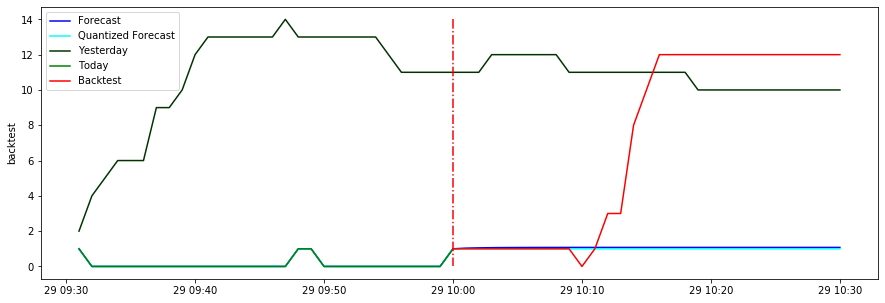

36 / 97
Best parameters: ['add', True, None, 60, False, False]
RMSE: 8.011330505018535




In [158]:
i = 35
model_generation_viz(df_result.hour[i], 30, df_result.best_parameters[i])
print(i+1,"/",len(time_list)+1)
print("Best parameters:",df_result.best_parameters[i])
print("RMSE:",df_result.rmse_f_b[i])
print()
print()

Here comes the van

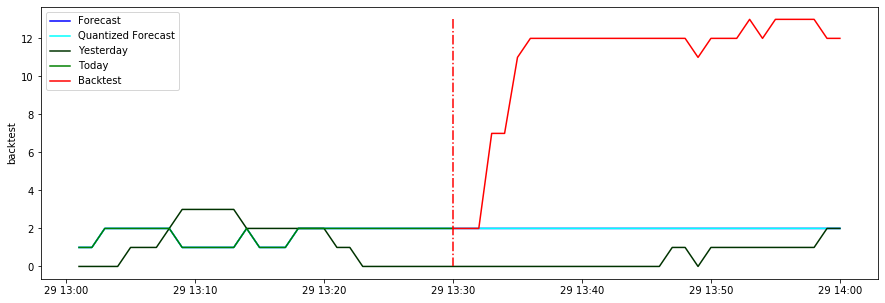

50 / 97
Best parameters: ['add', False, None, 60, False, False]
RMSE: 9.516652072376433




In [154]:
i = 49
model_generation_viz(df_result.hour[i], 30, df_result.best_parameters[i])
print(i+1,"/",len(time_list)+1)
print("Best parameters:",df_result.best_parameters[i])
print("RMSE:",df_result.rmse_f_b[i])
print()
print()

Here comes the van

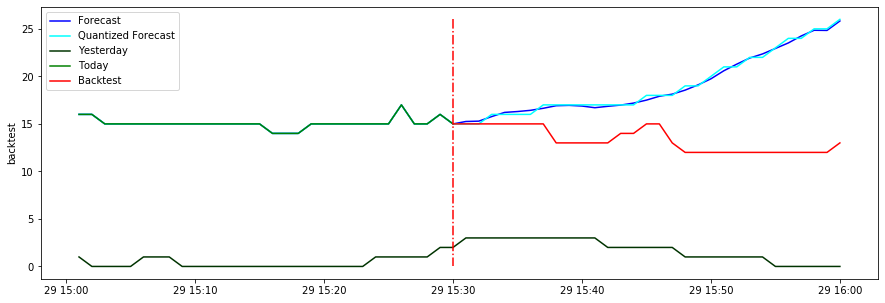

58 / 97
Best parameters: ['add', False, 'add', 60, False, False]
RMSE: 7.209517025008726




In [194]:
i = 57
model_generation_viz(df_result.hour[i], 30, df_result.best_parameters[i])
print(i+1,"/",len(time_list)+1)
print("Best parameters:",df_result.best_parameters[i])
print("RMSE:",df_result.rmse_f_b[i])
print()
print()

Here, the model is just inefficient!

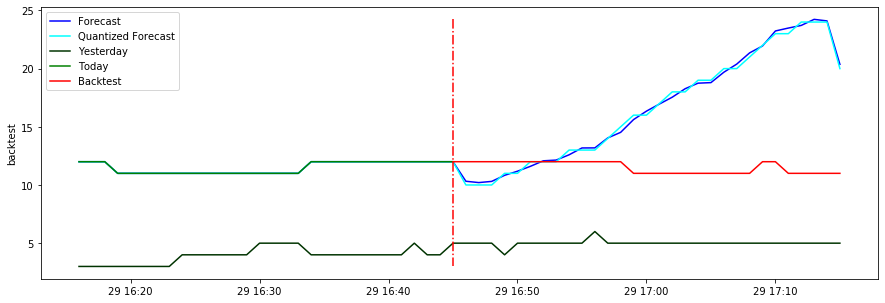

63 / 97
Best parameters: ['mul', False, 'mul', 60, True, False]
RMSE: 7.243780332022765




In [196]:
i = 62
model_generation_viz(df_result.hour[i], 30, df_result.best_parameters[i])
print(i+1,"/",len(time_list)+1)
print("Best parameters:",df_result.best_parameters[i])
print("RMSE:",df_result.rmse_f_b[i])
print()
print()

Here, the model is just inefficient too!


#### C. Final Assessement, with filter on the results

Here, we will remove 0 values and 10:00:00, 13:15:00 and 13:30:00 values

In [232]:
df_rmse = df_rmse[df_rmse["RMSE forecast vs backtest"] > 0]

In [235]:
df_rmse = df_rmse[(df_rmse.index != "10:00:00") & (df_rmse.index != "13:15:00") & (df_rmse.index != "13:30:00")]

In [243]:
df_rmse["round_results"] = df_rmse["RMSE forecast vs backtest"].apply(lambda x: round(x,2))

In [245]:
df_rmse.head()

,RMSE forecast vs backtest,round_results
hour,,
02:15:00,1.183546e-01,0.12
05:00:00,3.552714e-15,0.00
06:30:00,7.071068e-01,0.71
06:45:00,3.748908e-01,0.37
07:00:00,7.028547e-01,0.70


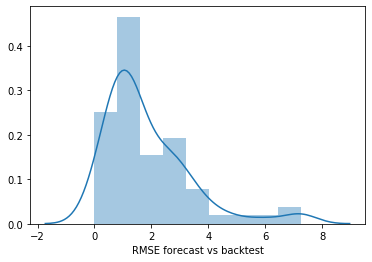

In [248]:
_ = sns.distplot(df_rmse["RMSE forecast vs backtest"])

In [249]:
df_rmse.describe()

,RMSE forecast vs backtest,round_results
count,6.400000e+01,64.000000
mean,1.861921e+00,1.862344
std,1.554018e+00,1.553656
min,3.552714e-15,0.000000
25%,8.730056e-01,0.877500
50%,1.366260e+00,1.370000
75%,2.557629e+00,2.557500
max,7.243780e+00,7.240000


In [254]:
# Number of predictions above 4 mistake
df_rmse[df_rmse["round_results"]>4].count() / df_rmse["round_results"].count()

RMSE forecast vs backtest    0.078125
round_results                0.078125
dtype: float64

### Final comments:

On this period, within 64 values, global mean is at 1,86, which is seems correct. There is still 8% of results which show an arror of 4 or more. In these situations, we can conclude the model was not efficient.